In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px # alternative to matplotlib that supports emojis
import nltk
from nltk.tokenize import TweetTokenizer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import regex as re
from collections import Counter
from wordcloud import WordCloud

import emoji
from unidecode import unidecode

import seaborn as sns
import tensorflow as tf
from sklearn import feature_extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                             recall_score)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf

from tqdm.notebook import tqdm
tqdm.pandas(colour="green")

import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

In [5]:
general_colour = "#8CC577"
mlm_colour = "#B077C5"

In [6]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /Users/wh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/wh/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /Users/wh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Dataset

In [7]:
df = pd.read_csv('data/dataset_large.csv', encoding="utf-8", engine="python")
df.head(10)

label                                       post_content
0   mlm  "💡𝐃𝐢𝐝 𝐲𝐨𝐮 𝐤𝐧𝐨𝐰 —what sets us apart from any ot...
1   mlm  "Share this with a biz bff or your stories to ...
2   mlm  "If you could scroll through our phones you’d ...
3   mlm  "Radiant Skin Starts Here 🌟\n\nGive your skin ...
4   mlm  "✨ *First winter glow update!* ✨ \n\nToday I n...
5   mlm  "imagine if I had quit after just 30 days 👀 \n...
6   mlm  "Hit that follow button + comment “444” and I’...
7   mlm  "The Primerica business opportunity could be a...
8   mlm  "You don’t have to look a certain way or have ...
9   mlm  "Learn what we do at Primerica and how we help...

In [8]:
df["label"].replace({"general": 0, "mlm": 1}, inplace=True)
df.rename({"label": "is_mlm", "post_content": "content"}, axis=1, inplace=True)
df.head(10)

is_mlm                                            content
0       1  "💡𝐃𝐢𝐝 𝐲𝐨𝐮 𝐤𝐧𝐨𝐰 —what sets us apart from any ot...
1       1  "Share this with a biz bff or your stories to ...
2       1  "If you could scroll through our phones you’d ...
3       1  "Radiant Skin Starts Here 🌟\n\nGive your skin ...
4       1  "✨ *First winter glow update!* ✨ \n\nToday I n...
5       1  "imagine if I had quit after just 30 days 👀 \n...
6       1  "Hit that follow button + comment “444” and I’...
7       1  "The Primerica business opportunity could be a...
8       1  "You don’t have to look a certain way or have ...
9       1  "Learn what we do at Primerica and how we help...

In [9]:
df.tail(10)

is_mlm                                            content
4990       0  "Self-care with Mr. Jack-o’-lantern 🎃\nDoing t...
4991       0  "Revolutionize your projects with Hubbell Edge...
4992       0  "Tag someone who need to see this! ❤️ Leveling...
4993       0  "Our entire family is loving it. Getting our b...
4994       0  "Beat the heat with @mrcoolcomfort ❄️🇺🇸\nWe ar...
4995       0  "Upgrade your lawn game with the 42” Z6 Zero T...
4996       0  "Heating up the yard with our @egopowerplus EG...
4997       0  "Shop smarter, not harder with the @shopkick A...
4998       0  "Absolutely loving our new Trillium greenhouse...
4999       0  "Type 1 = believes everyone and everything….\n...

In [10]:
df.shape

(5000, 2)

In [11]:
# Find duplicates excluding the first occurrence
duplicate_rows = df[df.duplicated(subset=["content"], keep='first')]

print(duplicate_rows)

Empty DataFrame
Columns: [is_mlm, content]
Index: []


In [12]:
# Extract sample post to understand post structure and format
sample = df.loc[1988]
print(sample['content'])

".\n𝙄𝙉𝘾𝙊𝙈𝙄𝙉𝙂… 𝗦𝗨𝗠𝗠𝗘𝗥 𝗕𝗢𝗗𝗜𝗘𝗦 🔥🔥🔥\n\n28 ELEVATE - The GTC's 28 Day Elevate Challenge!\n\n⁣28 Days of full accountability on your program, ticking off your health & wellness goals & always finding a new ⁣level!\n\nWE'VE GOT YOUR BACK 🙌🏻\n\nChallenge starts 23RD OCTOBER!\n\nAs you guys already know... we love to elevate & get the best out of ourselves. So what better way to finish 2023 and keep striving for new goals!⁣\n\nIf this is your first challenge... just you wait!⁣\n\n💻 Private Facebook Group⁣\n\n💪🏼 At-Home Workouts⁣\n\n💡 Facebook Live Q&A's⁣\n\n📕 Recipe Book⁣\n\n📈 Goal Setting Blueprint⁣\n\n🥙 Fakeaway Nights⁣\n\n𝘈𝘕𝘕𝘕𝘕𝘋𝘋𝘋... 𝘈𝘞𝘌𝘚𝘖𝘔𝘌 𝘗𝘙𝘐𝘡𝘌𝘚 𝘍𝘖𝘙 𝘛𝘏𝘌 𝘞𝘐𝘕𝘕𝘌𝘙𝘚 🙌🏼⁣\n\nWho is joining me?!!\nReach out for more info!\n\n#choosewellness #28daychallenge #weightloss #musclegain #slayyourgoals #areyourready #overallwellness #healthylifestyle #healthylifestylehabits #letsdothis #thechallengeison #livethelifeyouchoose #elevate #28elevate #incomingsummerbody"


# Feature engineering

In [13]:
# Word regex
word_regex = re.compile(r"\w+")

# Uppercase regex (Unicode aware)
upper_word_regex = re.compile(r'\b\p{Lu}+\b', re.UNICODE)

# Emoji regex
emojis = sorted(emoji.EMOJI_DATA, key=len, reverse=True)
emoji_pattern = '(' + '|'.join(re.escape(e) for e in emojis) + ')'
emoji_regex = re.compile(emoji_pattern)

# Unicode regex (excluding emojis)
unicode_letter_regex = re.compile(r"\p{L}", re.UNICODE)
unicode_word_regex = re.compile(r"\b[\p{L}]+\b", re.UNICODE)

# Hashtag regex
hashtag_regex = re.compile(r"(#[\w]+)")

In [14]:
def compute_metrics(row):
    content = row.content

     # Extract all emojis
    emojis_used = emoji_regex.findall(content)

    # Remove duplicate emojis
    unique_emojis_used = list(set(emojis_used))

    # Remove emoji components (ZWJ parts, variation selectors, flags that aren't full emojis)
    unique_emojis_used = [e for e in unique_emojis_used if e in emoji.EMOJI_DATA]

    # Extract hashtags
    hashtags_used = hashtag_regex.findall(content)
    
    return {
        "word_count": len(word_regex.findall(content)),
        "length": len(content),
        "upper_char_count": sum(1 for c in content if c.isupper()),
        "upper_word_count": len(upper_word_regex.findall(content)),
        "unicode_letter_count": sum(1 for c in content if unicode_letter_regex.match(c) and not emoji_regex.search(c)),
        "unicode_word_count": sum(1 for word in unicode_word_regex.findall(content) if any(ord(c) > 127 for c in word) and not emoji_regex.search(word)),
        "emoji_count": len(emojis_used),
        "emojis_used": ", ".join(emojis_used),
        "unique_emojis_used": ", ".join(unique_emojis_used),
        "hashtag_count": len(hashtags_used),
        "hashtags_used": ", ".join(hashtags_used)
    }

In [15]:
# Derive all metric data
metrics = df.progress_apply(compute_metrics, axis=1)

# Create metric dataframe
metrics_df = pd.DataFrame(metrics.tolist())
metrics_df.head()

  0%|          | 0/5000 [00:00<?, ?it/s]

word_count  length  upper_char_count  upper_word_count  \
0         195    1254                94                 6   
1          29     128                 2                 0   
2         113     770                 8                 1   
3         187    1121                50                 3   
4         156     931                26                 7   

   unicode_letter_count  unicode_word_count  emoji_count  \
0                  1021                  44           11   
1                    88                   0            1   
2                   629                   0            1   
3                   869                   0           11   
4                   723                   0            6   

                        emojis_used             unique_emojis_used  \
0   💡, 🌿, 💧, 🧪, 💫, 🪞, ✅, ✅, ✅, ✨, 🔬      🧪, 💫, 💧, 🪞, ✅, 💡, ✨, 🔬, 🌿   
1                                 👇                              👇   
2                                 🔥                              🔥   
3  🌟, 💧, 🌿, ✨, 🌸, 📦, 👉, 💕, 📲, 🌟, ⬇️  💧, 📦, 📲, 👉, 🌟, 🌸, ✨, 💕, ⬇️, 🌿   
4                 ✨, ✨, 🧴, 💧, ❄️, ✨                    ✨, 🧴, ❄️, 💧   

   hashtag_count                                      hashtags_used  
0              9  #JejuIslandBeauty, #GiantByoungpool, #KBeautyT...  
1              0                                                     
2             13  #gutreset, #guthealthy, #guthealthiseverything...  
3              8  #ForeverLiving, #SonyaSkincare, #AloeVeraCare,...  
4             10  #WinterGlow, #SkinCareJourney, #HealthySkin, #...

In [16]:
# Merge with original dataframe
feature_df = pd.concat([df, metrics_df], axis=1)

feature_df.head(10)

is_mlm                                            content  word_count  \
0       1  "💡𝐃𝐢𝐝 𝐲𝐨𝐮 𝐤𝐧𝐨𝐰 —what sets us apart from any ot...         195   
1       1  "Share this with a biz bff or your stories to ...          29   
2       1  "If you could scroll through our phones you’d ...         113   
3       1  "Radiant Skin Starts Here 🌟\n\nGive your skin ...         187   
4       1  "✨ *First winter glow update!* ✨ \n\nToday I n...         156   
5       1  "imagine if I had quit after just 30 days 👀 \n...         193   
6       1  "Hit that follow button + comment “444” and I’...          83   
7       1  "The Primerica business opportunity could be a...          44   
8       1  "You don’t have to look a certain way or have ...          38   
9       1  "Learn what we do at Primerica and how we help...          39   

   length  upper_char_count  upper_word_count  unicode_letter_count  \
0    1254                94                 6                  1021   
1     128                 2                 0                    88   
2     770                 8                 1                   629   
3    1121                50                 3                   869   
4     931                26                 7                   723   
5    1012                46                16                   786   
6     497                 5                 2                   386   
7     259                 8                 0                   209   
8     213                 8                 0                   170   
9     232                 6                 0                   187   

   unicode_word_count  emoji_count                       emojis_used  \
0                  44           11   💡, 🌿, 💧, 🧪, 💫, 🪞, ✅, ✅, ✅, ✨, 🔬   
1                   0            1                                 👇   
2                   0            1                                 🔥   
3                   0           11  🌟, 💧, 🌿, ✨, 🌸, 📦, 👉, 💕, 📲, 🌟, ⬇️   
4                   0            6                 ✨, ✨, 🧴, 💧, ❄️, ✨   
5                   0            3                          👀, 🥤, 🫶🏼   
6                   0            1                             🙋🏼‍♀️   
7                   0            0                                     
8                   0            0                                     
9                   0            0                                     

              unique_emojis_used  hashtag_count  \
0      🧪, 💫, 💧, 🪞, ✅, 💡, ✨, 🔬, 🌿              9   
1                              👇              0   
2                              🔥             13   
3  💧, 📦, 📲, 👉, 🌟, 🌸, ✨, 💕, ⬇️, 🌿              8   
4                    ✨, 🧴, ❄️, 💧             10   
5                       🥤, 👀, 🫶🏼              0   
6                          🙋🏼‍♀️              7   
7                                             0   
8                                             1   
9                                             0   

                                       hashtags_used  
0  #JejuIslandBeauty, #GiantByoungpool, #KBeautyT...  
1                                                     
2  #gutreset, #guthealthy, #guthealthiseverything...  
3  #ForeverLiving, #SonyaSkincare, #AloeVeraCare,...  
4  #WinterGlow, #SkinCareJourney, #HealthySkin, #...  
5                                                     
6  #guthealth, #wellnessjourney, #healyourgut, #i...  
7                                                     
8                              #YouCanTakeControlNow  
9

In [17]:
feature_df.describe()

is_mlm  word_count       length  upper_char_count  \
count  5000.00000  5000.00000  5000.000000       5000.000000   
mean      0.50000    95.77540   542.800800         18.773400   
std       0.50005    92.44454   506.756913         26.511919   
min       0.00000     0.00000     3.000000          0.000000   
25%       0.00000    23.00000   137.000000          3.000000   
50%       0.50000    63.00000   374.000000         10.000000   
75%       1.00000   145.00000   811.000000         26.000000   
max       1.00000   465.00000  2245.000000        841.000000   

       upper_word_count  unicode_letter_count  unicode_word_count  \
count        5000.00000           5000.000000         5000.000000   
mean            3.70380            419.510000            0.695000   
std             6.13609            393.604396            4.501203   
min             0.00000              0.000000            0.000000   
25%             0.00000            106.000000            0.000000   
50%             1.00000            288.000000            0.000000   
75%             5.00000            629.250000            0.000000   
max           172.00000           1802.000000           87.000000   

       emoji_count  hashtag_count  
count  5000.000000    5000.000000  
mean      2.910400       4.000000  
std       4.368683       6.446356  
min       0.000000       0.000000  
25%       0.000000       0.000000  
50%       1.000000       0.000000  
75%       4.000000       6.000000  
max      42.000000      31.000000

In [18]:
# Use sample to examine feature metrics
feature_sample = feature_df.loc[1988]
print(feature_sample['content'])
print("\nColumns:\n")
print(feature_sample)

".\n𝙄𝙉𝘾𝙊𝙈𝙄𝙉𝙂… 𝗦𝗨𝗠𝗠𝗘𝗥 𝗕𝗢𝗗𝗜𝗘𝗦 🔥🔥🔥\n\n28 ELEVATE - The GTC's 28 Day Elevate Challenge!\n\n⁣28 Days of full accountability on your program, ticking off your health & wellness goals & always finding a new ⁣level!\n\nWE'VE GOT YOUR BACK 🙌🏻\n\nChallenge starts 23RD OCTOBER!\n\nAs you guys already know... we love to elevate & get the best out of ourselves. So what better way to finish 2023 and keep striving for new goals!⁣\n\nIf this is your first challenge... just you wait!⁣\n\n💻 Private Facebook Group⁣\n\n💪🏼 At-Home Workouts⁣\n\n💡 Facebook Live Q&A's⁣\n\n📕 Recipe Book⁣\n\n📈 Goal Setting Blueprint⁣\n\n🥙 Fakeaway Nights⁣\n\n𝘈𝘕𝘕𝘕𝘕𝘋𝘋𝘋... 𝘈𝘞𝘌𝘚𝘖𝘔𝘌 𝘗𝘙𝘐𝘡𝘌𝘚 𝘍𝘖𝘙 𝘛𝘏𝘌 𝘞𝘐𝘕𝘕𝘌𝘙𝘚 🙌🏼⁣\n\nWho is joining me?!!\nReach out for more info!\n\n#choosewellness #28daychallenge #weightloss #musclegain #slayyourgoals #areyourready #overallwellness #healthylifestyle #healthylifestylehabits #letsdothis #thechallengeison #livethelifeyouchoose #elevate #28elevate #incomingsummerbody"

Columns:

is_mlm                      

# Analyse data

In [19]:
from collections import Counter

general_df = pd.DataFrame.from_dict(
    Counter(" ".join(df[df['is_mlm'] == 0]["content"]).split()).most_common(20)
)
general_df = general_df.rename(columns={0: "word_in_general", 1 : "frequency"})
                 
mlm_df = pd.DataFrame.from_dict(
    Counter(" ".join(df[df['is_mlm'] == 1]["content"]).split()).most_common(20)
)
mlm_df = mlm_df.rename(columns={0: "word_in_mlm", 1 : "frequency"})

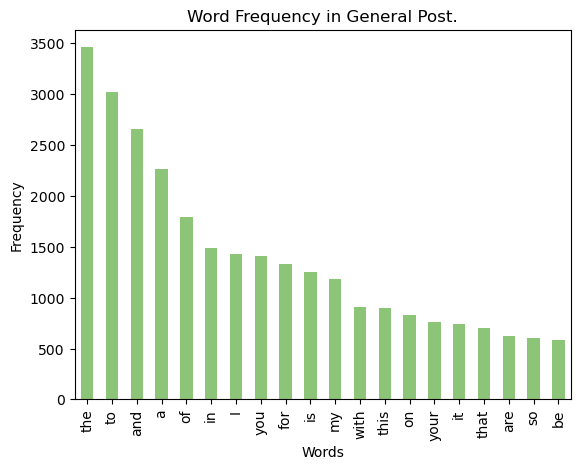

In [20]:
general_df.plot.bar(legend=False, color=general_colour)
plt.xticks(np.arange(len(general_df["word_in_general"])), general_df["word_in_general"])
plt.title("Word Frequency in General Post.")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

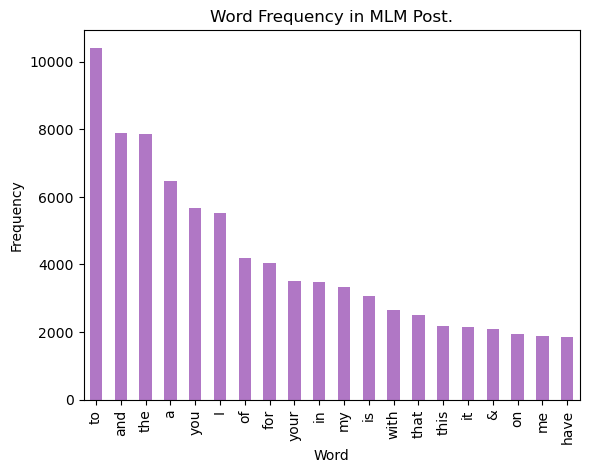

In [21]:
mlm_df.plot.bar(legend=False, color=mlm_colour)
plt.xticks(np.arange(len(mlm_df["word_in_mlm"])), mlm_df["word_in_mlm"])
plt.title("Word Frequency in MLM Post.")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.show()

Stop words are the most frequent in both

## Length

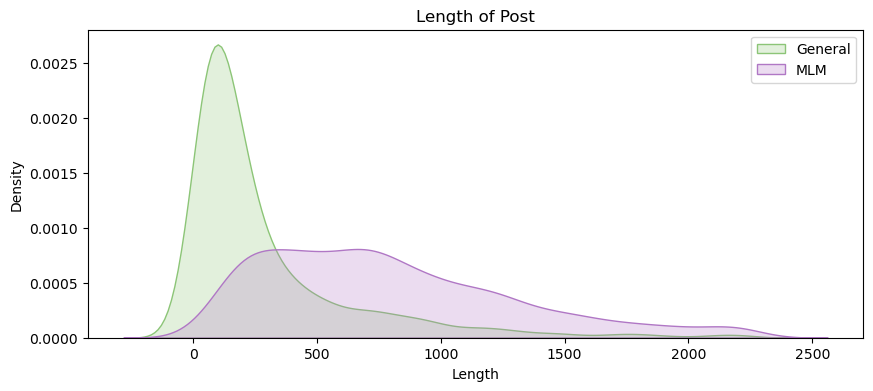

In [22]:
_, ax = plt.subplots(figsize=(10, 4))
sns.kdeplot(
    feature_df.loc[feature_df.is_mlm == 0, "length"],
    fill=True,
    label="General",
    color=general_colour
)
sns.kdeplot(feature_df.loc[feature_df.is_mlm == 1, "length"], fill=True, color=mlm_colour, label="MLM")
ax.set(
    xlabel="Length",
    ylabel="Density",
    title="Length of Post",
)
ax.legend(loc="upper right")
plt.show()

## Words

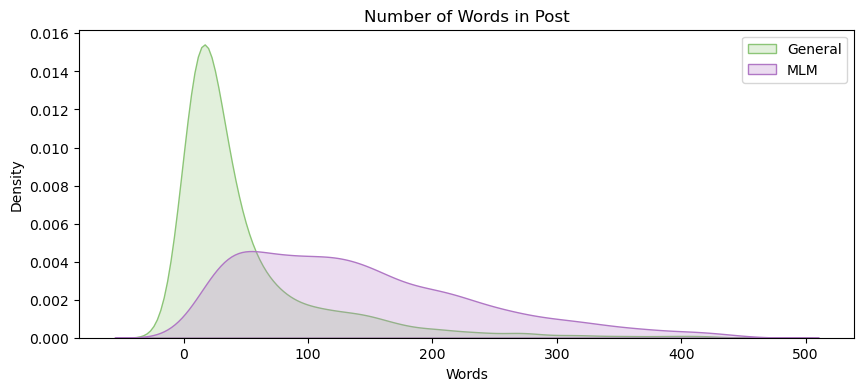

In [23]:
_, ax = plt.subplots(figsize=(10, 4))
sns.kdeplot(
    feature_df.loc[feature_df.is_mlm == 0, "word_count"],
    fill=True,
    color=general_colour,
    label="General"
)
sns.kdeplot(feature_df.loc[feature_df.is_mlm == 1, "word_count"], fill=True, color=mlm_colour, label="MLM")
ax.set(
    xlabel="Words",
    ylabel="Density",
    title="Number of Words in Post",
)
ax.legend(loc="upper right")
plt.show()

MLM posts tend to be longer and more variable in length compared to General posts which peak sharply around 20-50 words and drop off quickly after ~100 words / ~500 letters.

## Uppercased letters

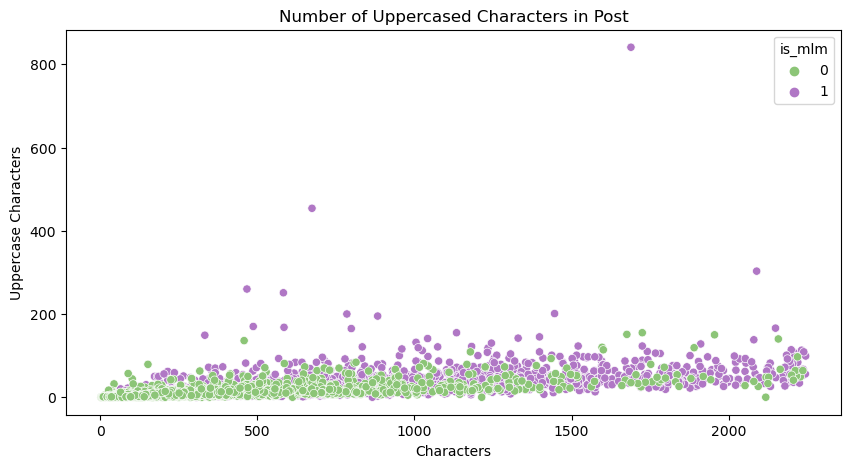

In [24]:
_, ax = plt.subplots(figsize=(10, 5))
ax = sns.scatterplot(x="length", y="upper_char_count", hue="is_mlm", data=feature_df, palette={0: general_colour, 1: mlm_colour})
ax.set(
    xlabel="Characters",
    ylabel="Uppercase Characters",
    title="Number of Uppercased Characters in Post"
)
ax.legend(loc="upper right", title="is_mlm")
plt.show()

MLM posts use significantly more uppercase characters than general posts, most likely for attention-grabbing purposes, and have some outliers with extremely high uppercase usage. Even when they're long general posts tend to have lower uppercase usage counts.

## Uppercased words

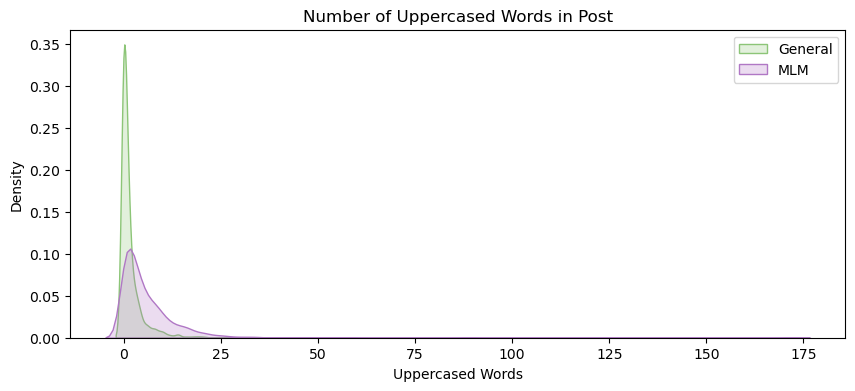

In [25]:
_, ax = plt.subplots(figsize=(10, 4))
sns.kdeplot(
    feature_df.loc[feature_df.is_mlm == 0, "upper_word_count"],
    fill=True,
    color=general_colour,
    label="General"
)
sns.kdeplot(feature_df.loc[feature_df.is_mlm == 1, "upper_word_count"], fill=True, color=mlm_colour, label="MLM")
ax.set(
    xlabel="Uppercased Words",
    ylabel="Density",
    title="Number of Uppercased Words in Post",
)
ax.legend(loc="upper right")
plt.show()

MLM posts tend to have more uppercase words with some extreme cases exceeding 50-100 uppercase words. But most posts in both categories use very few uppercase words, with general posts rarely exceeding 10.

## Emojis

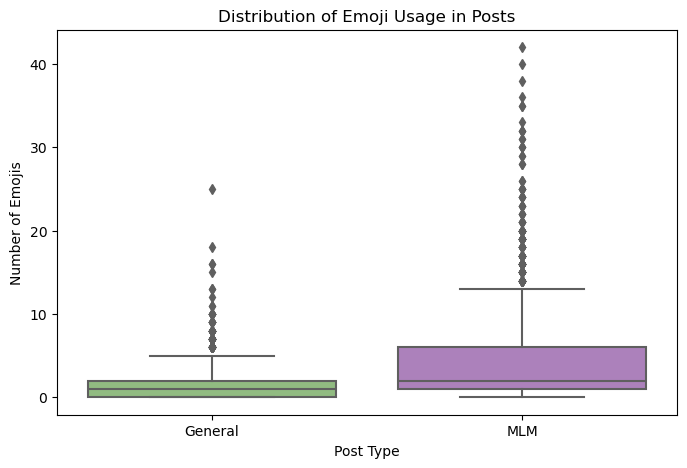

In [26]:
plt.figure(figsize=(8,5))
sns.boxplot(x="is_mlm", y="emoji_count", data=feature_df, palette=[general_colour, mlm_colour])
plt.xticks([0, 1], ["General", "MLM"])
plt.xlabel("Post Type")
plt.ylabel("Number of Emojis")
plt.title("Distribution of Emoji Usage in Posts")
plt.show()


MLM posts use more emojis on average and have a wider range of usage with more extreme outliers (some using 40+ emojis).

### Unique per post emoji counts

In [27]:
# Flatten emoji lists and remove empty values
mlm_emojis = feature_df[feature_df["is_mlm"] == 1]["unique_emojis_used"].str.split(", ").explode()
mlm_emojis = mlm_emojis.dropna().replace("", None).dropna()  # Remove empty emojis

general_emojis = feature_df[feature_df["is_mlm"] == 0]["unique_emojis_used"].str.split(", ").explode()
general_emojis = general_emojis.dropna().replace("", None).dropna()  # Remove empty emojis

# Count occurrences of each unique emoji
mlm_emoji_counts = Counter(mlm_emojis)
general_emoji_counts = Counter(general_emojis)

# Convert to dataframe
mlm_per_post_emoji_df = pd.DataFrame(mlm_emoji_counts.items(), columns=["emoji", "count"]).sort_values(by="count", ascending=False)
general_per_post_emoji_df = pd.DataFrame(general_emoji_counts.items(), columns=["emoji", "count"]).sort_values(by="count", ascending=False)

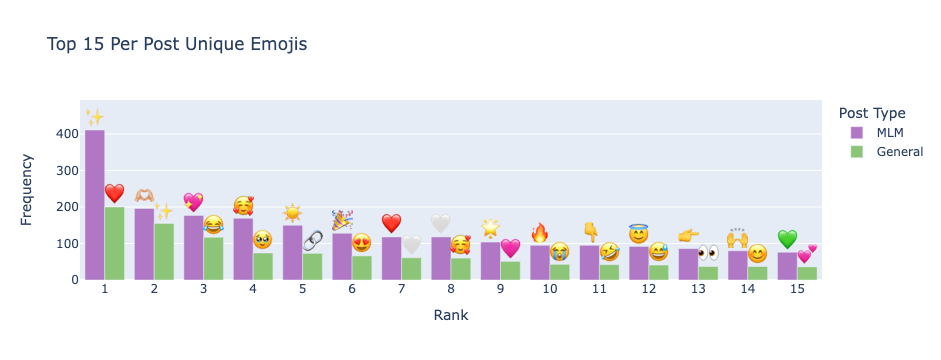

In [28]:
# Use plotly for emoji support

def plot_top_emojis(mlm_df, general_df, title):
    # Make copies to avoid modifying the originals
    mlm_df = mlm_df.copy()
    general_df = general_df.copy()

    # Assign ranks based on emoji count
    mlm_df["Rank"] = range(1, len(mlm_df) + 1)
    general_df["Rank"] = range(1, len(general_df) + 1)

    # Post type
    mlm_df["Post Type"] = "MLM"
    general_df["Post Type"] = "General"

    # Concatenate
    combined_df = pd.concat([mlm_df[:15], general_df[:15]])

    # Add demojized descriptions
    combined_df["emoji_desc"] = combined_df["emoji"].apply(lambda e: emoji.demojize(e))

    # Create a grouped bar chart where X-axis is Rank
    fig = px.bar(combined_df, x="Rank", y="count", text="emoji",
                 color="Post Type", barmode="group",
                 title=title, color_discrete_map={"MLM": mlm_colour, "General": general_colour},
                 hover_data={"emoji": True, "emoji_desc": True, "count": True})

    # Max count for additional Y-axis padding
    max_y = combined_df["count"].max()
    
    # Adjust layout
    fig.update_traces(textfont_size=20, textangle=0, textposition="outside")
    fig.update_layout(
        xaxis_title="Rank",
        yaxis_title="Frequency",
        yaxis=dict(range=[0, max_y + max_y * 0.20]),
        xaxis=dict(tickmode="array", tickvals=combined_df["Rank"], ticktext=combined_df["Rank"]),
        margin=dict(t=100)
    )
    
    fig.show()


plot_top_emojis(mlm_per_post_emoji_df, general_per_post_emoji_df, "Top 15 Per Post Unique Emojis")

This chart reaffirms that MLM posts use emojis more frequently and that even though they share many emojis in common, the ones most used my mlm distributors are particularly expressive, affectionate and celebratory.

### Total emoji counts 

In [29]:
# Flatten all emojis
mlm_emojis = feature_df[feature_df["is_mlm"] == 1]["emojis_used"].str.split(", ").explode()
mlm_emojis = mlm_emojis.dropna().replace("", None).dropna()

general_emojis = feature_df[feature_df["is_mlm"] == 0]["emojis_used"].str.split(", ").explode()
general_emojis = general_emojis.dropna().replace("", None).dropna()  # Remove empty emojis

# Count total occurrences
mlm_emoji_counts = Counter(mlm_emojis)  
general_emoji_counts = Counter(general_emojis)  

# Convert to dataframe
mlm_emoji_df = pd.DataFrame(mlm_emoji_counts.items(), columns=["emoji", "count"]).sort_values(by="count", ascending=False)
general_emoji_df = pd.DataFrame(general_emoji_counts.items(), columns=["emoji", "count"]).sort_values(by="count", ascending=False)

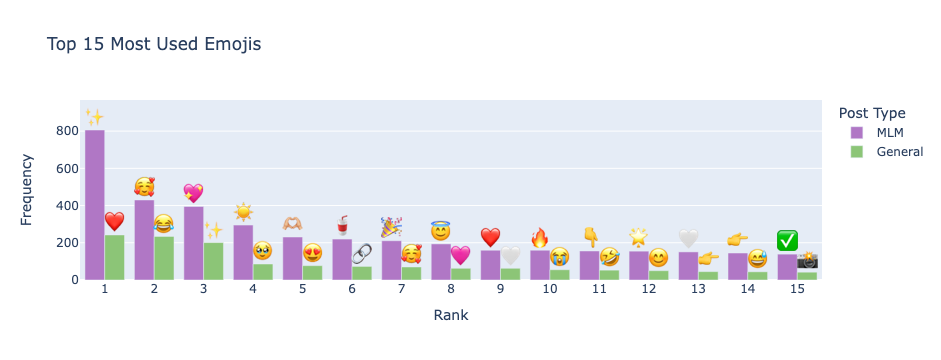

In [30]:
plot_top_emojis(mlm_emoji_df, general_emoji_df, "Top 15 Most Used Emojis")

The sparkles (✨) and smiling face with hearts (🥰) emojis appear four to nearly six times more often in MLM posts. Based on the previous graph of unique per post emojis they must commonly occur multiple time within the same post.

### MLM exclusive emojis

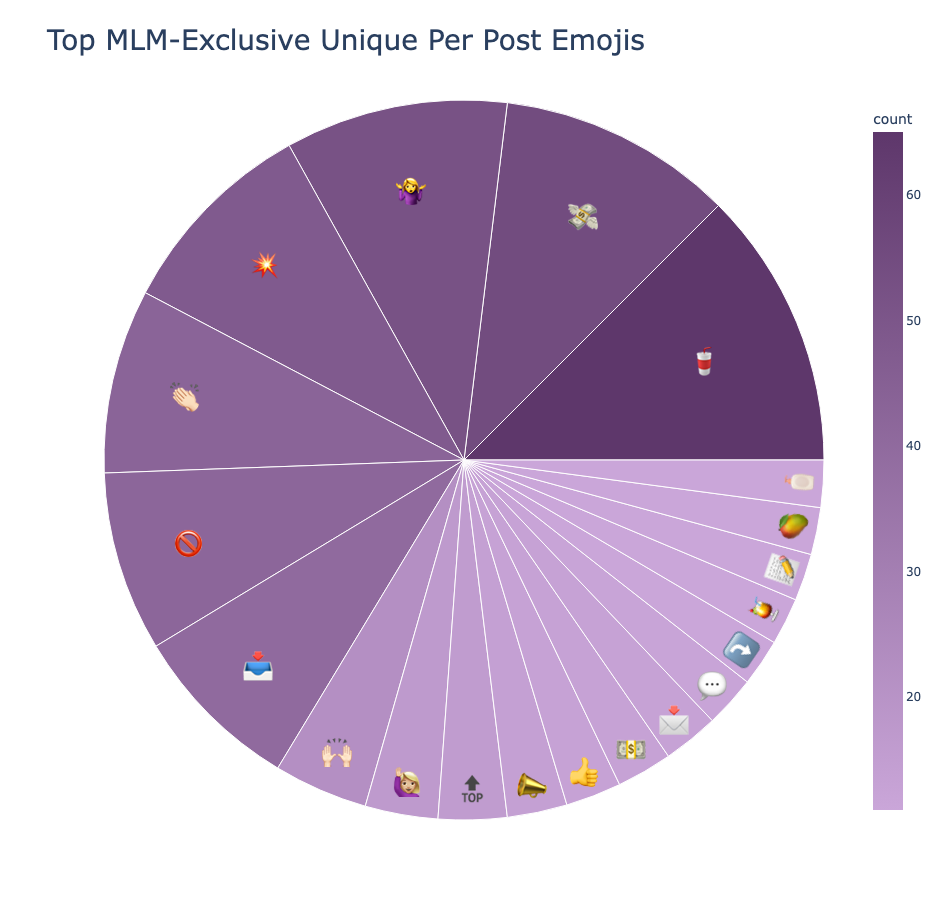

In [31]:
# Find emojis unique to MLM
mlm_exclusive_emojis = set(mlm_per_post_emoji_df["emoji"]) - set(general_per_post_emoji_df["emoji"])

# Filter MLM-exclusive emojis
mlm_unique_df = mlm_per_post_emoji_df[mlm_per_post_emoji_df["emoji"].isin(mlm_exclusive_emojis)]

# Explicit copy to avoid SettingWithCopyWarning
mlm_unique_df = mlm_unique_df.copy()

# Add emoji descriptions for hover tooltips
mlm_unique_df["emoji_desc"] = mlm_unique_df["emoji"].apply(lambda e: emoji.demojize(e))

# Sunburst Chart
fig = px.sunburst(mlm_unique_df[:20],
                  path=["emoji"],
                  values="count",
                  title="Top MLM-Exclusive Unique Per Post Emojis",
                  hover_data={"emoji_desc": True, "count": True},
                  color="count",
                  color_continuous_scale=["#caa6d9", "#5e376b"])

# Font size
fig.update_traces(textfont_size=30)

# Background
fig.update_layout(template="plotly_white",
    paper_bgcolor="white",
    plot_bgcolor="white",
    title_font_size=28,
    width=900,
    height=900
)

fig.show()

MLM's uniquely use a variety of product, financial, and communication-related emojis. The presence of specific skin tone variations on more common clapping and hand raising emojis is interesting because it suggests MLM posts might use more personalised or inclusive emoji variations.

## Hashtags

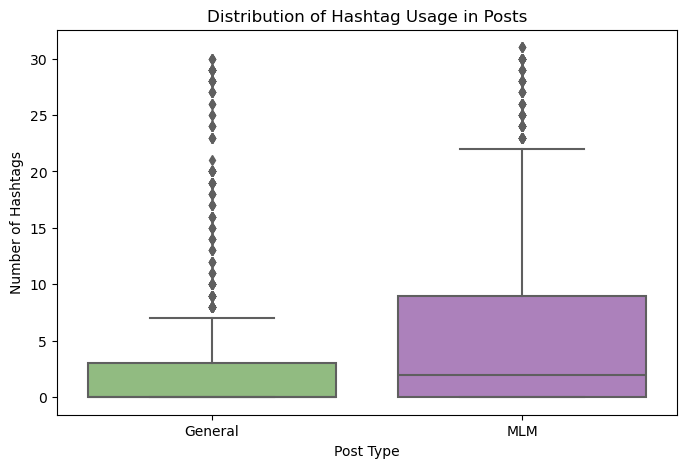

In [32]:
plt.figure(figsize=(8,5))
sns.boxplot(x="is_mlm", y="hashtag_count", data=feature_df, palette=[general_colour, mlm_colour])
plt.xticks([0, 1], ["General", "MLM"])
plt.xlabel("Post Type")
plt.ylabel("Number of Hashtags")
plt.title("Distribution of Hashtag Usage in Posts")
plt.show()

MLM posts generally use more hashtags with greater variability but both have a significant number of outliers (some posts contain an exceptionally high number of hashtags).

In [33]:
# Flatten all hashtags
mlm_hashtags = feature_df[feature_df["is_mlm"] == 1]["hashtags_used"].str.split(", ").explode()
mlm_hashtags = mlm_hashtags.dropna().replace("", None).dropna()

general_hashtags = feature_df[feature_df["is_mlm"] == 0]["hashtags_used"].str.split(", ").explode()
general_hashtags = general_hashtags.dropna().replace("", None).dropna()

# Count occurrences of each hashtag
mlm_hashtag_counts = Counter(mlm_hashtags)
general_hashtag_counts = Counter(general_hashtags)

# Convert to dataframe
mlm_hashtag_df = pd.DataFrame(mlm_hashtag_counts.items(), columns=["hashtag", "count"]).sort_values(by="count", ascending=False)
general_hashtag_df = pd.DataFrame(general_hashtag_counts.items(), columns=["hashtag", "count"]).sort_values(by="count", ascending=False)

# Find hashtags unique to MLM
mlm_exclusive_hashtags = set(mlm_hashtag_df["hashtag"]) - set(general_hashtag_df["hashtag"])

# Filter MLM-exclusive hashtags
mlm_unique_hashtag_df = mlm_hashtag_df[mlm_hashtag_df["hashtag"].isin(mlm_exclusive_hashtags)]

# Explicit copy to avoid SettingWithCopyWarning
mlm_unique_hashtag_df = mlm_unique_hashtag_df.copy()

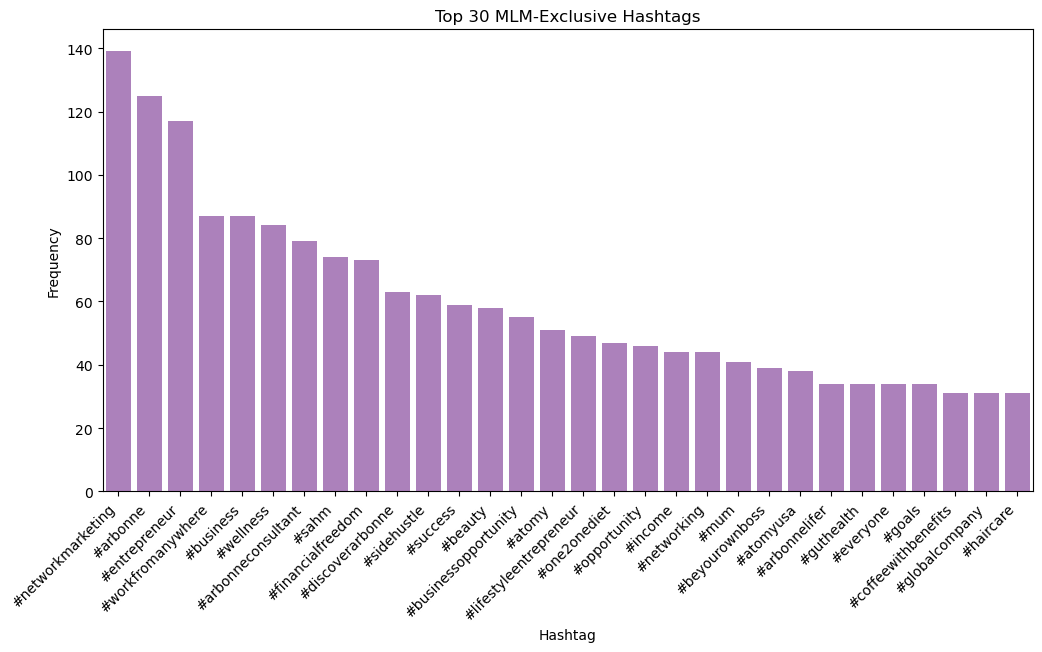

In [34]:
plt.figure(figsize=(12, 6))
sns.barplot(data=mlm_unique_hashtag_df[:30], x="hashtag", y="count", color=mlm_colour)

plt.xticks(rotation=45, ha="right")
plt.xlabel("Hashtag")
plt.ylabel("Frequency")
plt.title("Top 30 MLM-Exclusive Hashtags")

plt.show()


The most frequently used unique MLM hashtags emphasise network marketing, entrepreneurship, financial freedom/success, motherhood, and wellness, as expected from the background history on MLM marketing tactics. The heavy presence of brand-specific hashtags suggests that certain MLM companies have a strong influence on hashtag usage.

## Unicode

### Letters

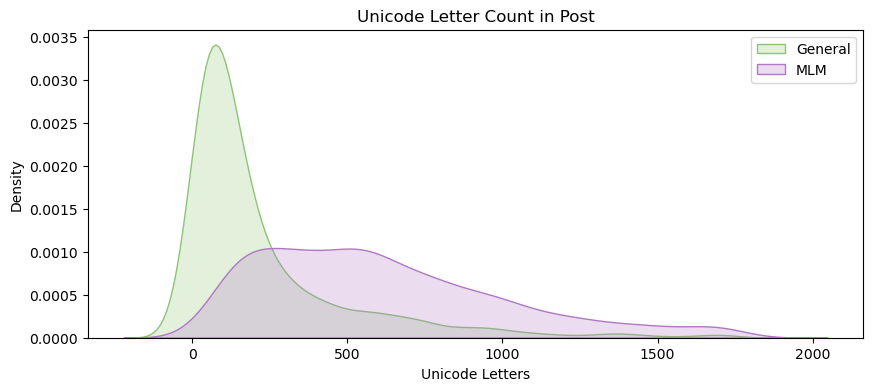

In [35]:
_, ax = plt.subplots(figsize=(10, 4))
sns.kdeplot(
    feature_df.loc[feature_df.is_mlm == 0, "unicode_letter_count"],
    fill=True,
    label="General",
    color=general_colour
)
sns.kdeplot(feature_df.loc[feature_df.is_mlm == 1, "unicode_letter_count"], fill=True, color=mlm_colour, label="MLM")
ax.set(
    xlabel="Unicode Letters",
    ylabel="Density",
    title="Unicode Letter Count in Post",
)
ax.legend(loc="upper right")
plt.show()

MLM posts have a wider spread and a higher average usage of Unicode letters which suggests that posts more frequently incorporate Unicode stylisation (decorative fonts or special characters) a finding that affirms our experience during the data collection process.

### Words

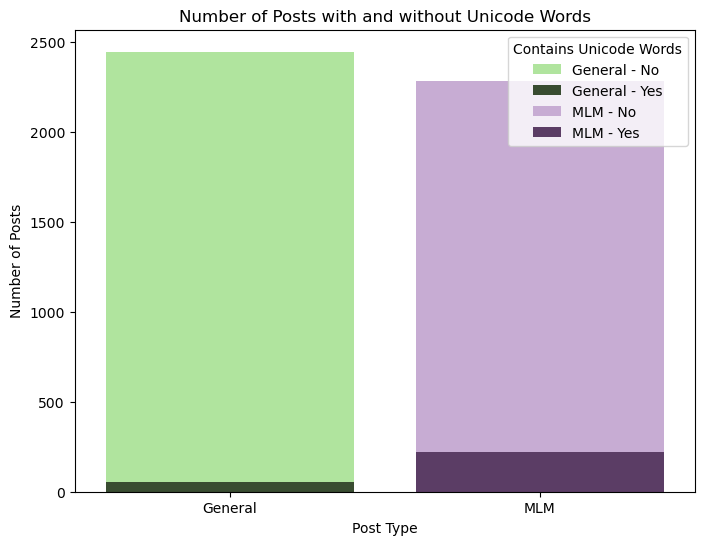

In [36]:
unicode_word_df = feature_df.copy()

# Check if post has unicode words
unicode_word_df["has_unicode_words"] = unicode_word_df["unicode_word_count"] > 0


# Count occurrences
unicode_presence = (
    unicode_word_df.groupby(["is_mlm", "has_unicode_words"])
    .size()
    .reset_index(name="Count")
)

# Category labels
unicode_presence["Post Type"] = unicode_presence["is_mlm"].map({0: "General", 1: "MLM"})

# Unicode words labels
unicode_presence["Unicode Words"] = unicode_presence["has_unicode_words"].map({True: "Yes", False: "No"})

# Custom palette
custom_palette = {
    "General - No": "#abf092",
    "General - Yes": "#37502d",
    "MLM - No": "#caa6d9",
    "MLM - Yes": "#5e376b"
}
unicode_presence["Group"] = unicode_presence["Post Type"] + " - " + unicode_presence["Unicode Words"]

plt.figure(figsize=(8, 6))
sns.barplot(data=unicode_presence, x="Post Type", y="Count", hue="Group",
           palette=custom_palette, dodge=False)
plt.xticks(rotation=0)
plt.xlabel("Post Type")
plt.ylabel("Number of Posts")
plt.title("Number of Posts with and without Unicode Words")
plt.legend(title="Contains Unicode Words")

plt.show()

MLM posts are more likely to include Unicode words but overall the majority of posts (in both categories) do not contain them. We found this visualisation surprising given how prevalent stylised unicode MLM posts appeared to be during the data collection process. Though the previous graphs confirms that unicode letters are indeed more common in MLM posts, entire words are not frequently unicode stylised.

# Preprocessing Data

The posts contain a wide variety of formatting elements that need to be cleaned:
- Preserve hashtags and emojis (for their context and sentiment)
- Remove mentions and urls (prevent overfitting and protect privacy)
- Remove punctuation
- Replace newlines with spaces
- Replace punctuation with either spaces or empty spaces (try to preserve words as much as possible)
- Handle unicode text, convert it to normal text
- Convert to lowercase (optional)
- Normalise spaces

Punctuation and lowercasing are both optional to test if these params make a difference to the models down the line.

In [37]:
print(sample['content'])
print('\n')

".\n𝙄𝙉𝘾𝙊𝙈𝙄𝙉𝙂… 𝗦𝗨𝗠𝗠𝗘𝗥 𝗕𝗢𝗗𝗜𝗘𝗦 🔥🔥🔥\n\n28 ELEVATE - The GTC's 28 Day Elevate Challenge!\n\n⁣28 Days of full accountability on your program, ticking off your health & wellness goals & always finding a new ⁣level!\n\nWE'VE GOT YOUR BACK 🙌🏻\n\nChallenge starts 23RD OCTOBER!\n\nAs you guys already know... we love to elevate & get the best out of ourselves. So what better way to finish 2023 and keep striving for new goals!⁣\n\nIf this is your first challenge... just you wait!⁣\n\n💻 Private Facebook Group⁣\n\n💪🏼 At-Home Workouts⁣\n\n💡 Facebook Live Q&A's⁣\n\n📕 Recipe Book⁣\n\n📈 Goal Setting Blueprint⁣\n\n🥙 Fakeaway Nights⁣\n\n𝘈𝘕𝘕𝘕𝘕𝘋𝘋𝘋... 𝘈𝘞𝘌𝘚𝘖𝘔𝘌 𝘗𝘙𝘐𝘡𝘌𝘚 𝘍𝘖𝘙 𝘛𝘏𝘌 𝘞𝘐𝘕𝘕𝘌𝘙𝘚 🙌🏼⁣\n\nWho is joining me?!!\nReach out for more info!\n\n#choosewellness #28daychallenge #weightloss #musclegain #slayyourgoals #areyourready #overallwellness #healthylifestyle #healthylifestylehabits #letsdothis #thechallengeison #livethelifeyouchoose #elevate #28elevate #incomingsummerbody"




## Custom TweetTokenizer
Much later in the processing pipeline we discovered that the nltk TweetTokenizer, which is great at preserving contractions, hashtags and emojis, was splitting newer Zero Width Joiner (ZWJ) emojis like 🏳️‍🌈 into \['🏳', '️\u200d🌈'\] when they should really be tokenised as '🏳\u200d🌈'. This caused problems when one-hot-encoding the full list of emojis during the vectorisation phase. The regex nltk used to preserve these emojis was not sufficient [See REGEXPS](https://github.com/nltk/nltk/blob/e77c93243bb7eb1839324a8e2650e4d5f92b1ae4/nltk/tokenize/casual.py#L160):

```
    # Zero-Width-Joiner and Skin tone modifier emojis
    """.(?:
        [\U0001F3FB-\U0001F3FF]?(?:\u200d.[\U0001F3FB-\U0001F3FF]?)+
        |
        [\U0001F3FB-\U0001F3FF]
    )""",
```

We were therefore required to make a custom version of the TweetTokenizer that preserves all of the emojis in the emoji library. Our investigating found that this implementation (using the emoji library) was suggested many years ago, and noted as being favourable for keeping up to date with newer emojis. However regex was chosen for efficiency and a desire to keep minimal dependencies [See pull request](https://github.com/nltk/nltk/pull/2843).

In [38]:
import regex as re
from nltk.tokenize import TweetTokenizer
from nltk.tokenize.casual import REGEXPS  # Import original regex patterns

class CustomTweetTokenizer(TweetTokenizer):
    def __init__(self, preserve_case=True, reduce_len=False, strip_handles=False, match_phone_numbers=True):
        super().__init__(preserve_case=preserve_case, reduce_len=reduce_len, strip_handles=strip_handles, match_phone_numbers=match_phone_numbers)
        self._WORD_RE = None

    def tokenize(self, text):
        emoji_matches = emoji_regex.findall(text)

        cleaned_text = emoji_regex.sub(" EMOJI_PLACEHOLDER ", text)

        tokens = super().tokenize(cleaned_text)

        final_tokens = []
        emoji_index = 0

        for token in tokens:
            if token == "EMOJI_PLACEHOLDER":
                final_tokens.append(emoji_matches[emoji_index])
                emoji_index += 1
            else:
                final_tokens.append(token)

        return final_tokens


## Cleaning

In [39]:
negation_exceptions = {"not", "no", "never", "cannot"}
stopwords_list = set(stopwords.words("english")) - negation_exceptions

def is_emoji(token):
    return any(char in emoji.EMOJI_DATA for char in token)

def is_hashtag(token):
    return token.startswith('#') and any(ch.isalnum() for ch in token[1:])

def preserve_tokens(text):
    placeholders = {}
    token_id = 0

    def replace_hashtag(match):
        nonlocal token_id
        token = match.group(0)
        placeholder = f"XHT{token_id}X"  # Safe placeholder for hashtags
        placeholders[placeholder] = token
        token_id += 1
        return placeholder

    text = re.sub(hashtag_regex, replace_hashtag, text)

    def replace_emoji(match):
        nonlocal token_id
        token = match.group(0)
        placeholder = f"XEMOJI{token_id}X"  # Safe placeholder for emojis
        placeholders[placeholder] = token
        token_id += 1
        return placeholder

    text = emoji_regex.sub(replace_emoji, text)
    return text, placeholders

def restore_tokens(text, placeholders):
    for placeholder, token in placeholders.items():
        text = text.replace(placeholder, token)
    return text

def remove_symbols(text, for_ml_pipeline=True):
    # Remove unwanted symbols, preserve !, ?, ', -, (, ), periods and commas (avoiding placeholders XHTX/XEMOJIX)
    text = re.sub(r"[^\w\s#'!?\-.,!?()]", "", text)

    if for_ml_pipeline:
    
        # Replace repeated occurrences of the same symbol (except placeholders) !!! → !
        text = re.sub(r"([!?'-])\1+", r"\1", text)  
    
        # Remove standalone symbols (not attached to words)
        text = re.sub(r"(?<!\w)[.,!?()-]+(?!\w)", "", text)

    return text

def clean_text(text, for_ml_pipeline=True):
    # --- Pre-Cleaning ---
    # Replace newlines
    text = text.replace('\\n', ' ')

    # Remove mentions
    text = re.sub(r'@\w+', '', text)

    # Remove URLs
    text = re.sub(r'(https?://|www\.)[\w.-]+(?:\.[a-zA-Z]{2,})+(?:/[^\s]*)?', '', text)

    # Protect hashtags and emojis using safe placeholders for unidecode and symbol removal
    text_with_placeholders, placeholders = preserve_tokens(text)
    
    # Run unidecode
    decoded_text = unidecode(text_with_placeholders)

    # Remove symbols
    symbols_removed = remove_symbols(decoded_text, for_ml_pipeline)

     # Restore original hashtags and emojis
    restored_text = restore_tokens(symbols_removed, placeholders)

    # Custome TweetTokenizer (preserves emojis, hashtags, and contractions)
    tokens = CustomTweetTokenizer(strip_handles=False, reduce_len=True).tokenize(restored_text)
    
    processed_tokens=[]
    for token in tokens:
        if is_emoji(token):
            processed_tokens.append(token)  # preserve emojis
        elif is_hashtag(token):
            processed_tokens.append(token)  # preserve hashtags
        else:
            # Apply lemmatisation & stopword removal only if for ML pipeline
            if for_ml_pipeline:
                lemmatised_token = WordNetLemmatizer().lemmatize(token)
                if lemmatised_token.lower() not in stopwords_list:
                    processed_tokens.append(lemmatised_token)
            else:
                # Keep original token for sentiment analysis
                processed_tokens.append(token)          
                
    processed_text = " ".join(processed_tokens)
    if for_ml_pipeline:
        processed_text = processed_text.lower()

    # Normalise multiple spaces
    final_text = re.sub(r"\s+", " ", processed_text).strip()
    
    return final_text

In [40]:
print('Before cleaning:\n')
print(sample['content'] + '\n')
print('After cleaning:\n(Stopwords removed, lemmatised):\n')
print(clean_text(sample['content']))
print('\n(Stopwords not removed, not lemmatised):\n')
print(clean_text(sample['content'], for_ml_pipeline=False))

Before cleaning:

".\n𝙄𝙉𝘾𝙊𝙈𝙄𝙉𝙂… 𝗦𝗨𝗠𝗠𝗘𝗥 𝗕𝗢𝗗𝗜𝗘𝗦 🔥🔥🔥\n\n28 ELEVATE - The GTC's 28 Day Elevate Challenge!\n\n⁣28 Days of full accountability on your program, ticking off your health & wellness goals & always finding a new ⁣level!\n\nWE'VE GOT YOUR BACK 🙌🏻\n\nChallenge starts 23RD OCTOBER!\n\nAs you guys already know... we love to elevate & get the best out of ourselves. So what better way to finish 2023 and keep striving for new goals!⁣\n\nIf this is your first challenge... just you wait!⁣\n\n💻 Private Facebook Group⁣\n\n💪🏼 At-Home Workouts⁣\n\n💡 Facebook Live Q&A's⁣\n\n📕 Recipe Book⁣\n\n📈 Goal Setting Blueprint⁣\n\n🥙 Fakeaway Nights⁣\n\n𝘈𝘕𝘕𝘕𝘕𝘋𝘋𝘋... 𝘈𝘞𝘌𝘚𝘖𝘔𝘌 𝘗𝘙𝘐𝘡𝘌𝘚 𝘍𝘖𝘙 𝘛𝘏𝘌 𝘞𝘐𝘕𝘕𝘌𝘙𝘚 🙌🏼⁣\n\nWho is joining me?!!\nReach out for more info!\n\n#choosewellness #28daychallenge #weightloss #musclegain #slayyourgoals #areyourready #overallwellness #healthylifestyle #healthylifestylehabits #letsdothis #thechallengeison #livethelifeyouchoose #elevate #28elevate #incomingsummerbody"

After cleaning:
(Sto

In [41]:
sample2=feature_df.loc[1672]
print('Before cleaning:\n')
print(sample2['content'] + '\n')
print('After cleaning:\n(Stopwords removed, lemmatised):\n')
print(clean_text(sample2['content']))
print('\n(Stopwords not removed, not lemmatised):\n')
print(clean_text(sample2['content'], for_ml_pipeline=False))

Before cleaning:

"🥰Go passionately after the life you want!!!\n\n🔥 Use your excuses to push you forward & fuel you, not hold you back!🙈\n\n💖WHICH PERSON ARE YOU?💖\n\nPERSON 1\n\"I can't do it. I work a full time job. I am way too busy. I can't afford it. I'm in debt.\"\n\nPERSON 2\n\"I have to do it. I have debt. I want more time with my family. I want to provide in ways I am not able to and I would love an extra stream of income to help!”\n\n🙌I’m here to help Person 2, if this is you….reach out, \nLet’s have a talk & see if what I do could be a good fit for you! 🥰\n\nI live the life I always dreamed of because I decided one day to turn my excuses around!!🥰🙌🎉"

After cleaning:
(Stopwords removed, lemmatised):

🥰 go passionately life want ! 🔥 use excuse push forward fuel , not hold back ! 🙈 💖 person ? 💖 person 1 can't . work full time job . way busy . can't afford . debt . person 2 . debt . want time family . want provide way not able would love extra stream income help ! 🙌 help person

In [42]:
# Use sample to examine feature metrics
sample3 = feature_df.loc[2879]
print(sample3['content'] + '\n')
print('After cleaning:\n(Stopwords removed, lemmatised):\n')
print(clean_text(sample3['content']))
print('\n(Stopwords not removed, not lemmatised):\n')
print(clean_text(sample3['content'], for_ml_pipeline=False))

"pride month, and in case y’all didn’t know... 💗💛💙\n\ni think my sexuality makes sense with my autistic brain. for a while i figured i must be bisexual, but that didn’t fit that much... because for me, gender does not exist. i do not have a gender. sure, femininity, androgyny and masculinity exist (based off social constructs still, but at least this i can kinda understand). anyone can be feminine, anyone can be androgynous, anyone can be masculine, regardless of their gender identity. so how do i define my sexuality based off something so meaningless to me as gender? gender identity doesn’t equal body parts, which i don’t have a preference for. gender identity doesn’t equal gender expression, which i actually do have a preference for. but no gender identity preference, because gender? what? \ni guess this is me kinda also talking about my gender, which i’ve been confused about for a while, and i think i just, don’t have one.. gender just doesn’t feel right. gender doesn’t exist to me.

In [43]:
# Keeps all words for sentiment
tqdm.pandas(desc="Cleaning for sentiment")
feature_df["cleaned_for_sentiment"] = feature_df["content"].progress_apply(
    lambda content: clean_text(content, for_ml_pipeline=False)
)

# Removes stopwords & lemmatises
tqdm.pandas(desc="Cleaning for ML pipeline")
feature_df["cleaned_for_ml"] = feature_df["content"].progress_apply(
    lambda content: clean_text(content, for_ml_pipeline=True)
)

feature_df

Cleaning for sentiment:   0%|          | 0/5000 [00:00<?, ?it/s]

Cleaning for ML pipeline:   0%|          | 0/5000 [00:00<?, ?it/s]

is_mlm                                            content  word_count  \
0          1  "💡𝐃𝐢𝐝 𝐲𝐨𝐮 𝐤𝐧𝐨𝐰 —what sets us apart from any ot...         195   
1          1  "Share this with a biz bff or your stories to ...          29   
2          1  "If you could scroll through our phones you’d ...         113   
3          1  "Radiant Skin Starts Here 🌟\n\nGive your skin ...         187   
4          1  "✨ *First winter glow update!* ✨ \n\nToday I n...         156   
...      ...                                                ...         ...   
4995       0  "Upgrade your lawn game with the 42” Z6 Zero T...          23   
4996       0  "Heating up the yard with our @egopowerplus EG...          40   
4997       0  "Shop smarter, not harder with the @shopkick A...          30   
4998       0  "Absolutely loving our new Trillium greenhouse...          77   
4999       0  "Type 1 = believes everyone and everything….\n...          17   

      length  upper_char_count  upper_word_count  unicode_letter_count  \
0       1254                94                 6                  1021   
1        128                 2                 0                    88   
2        770                 8                 1                   629   
3       1121                50                 3                   869   
4        931                26                 7                   723   
...      ...               ...               ...                   ...   
4995     145                 7                 0                   107   
4996     218                 8                 1                   161   
4997     207                14                 0                   158   
4998     445                22                 3                   345   
4999     140                 1                 0                   109   

      unicode_word_count  emoji_count                       emojis_used  \
0                     44           11   💡, 🌿, 💧, 🧪, 💫, 🪞, ✅, ✅, ✅, ✨, 🔬   
1                      0            1                                 👇   
2                      0            1                                 🔥   
3                      0           11  🌟, 💧, 🌿, ✨, 🌸, 📦, 👉, 💕, 📲, 🌟, ⬇️   
4                      0            6                 ✨, ✨, 🧴, 💧, ❄️, ✨   
...                  ...          ...                               ...   
4995                   0            2                             🌿, 🇺🇸   
4996                   0            1                                🇺🇸   
4997                   0            3                           🛒, 💡, 🎁   
4998                   0            3                          🌿, ❤️, 💡   
4999                   0            0                                     

                 unique_emojis_used  hashtag_count  \
0         🧪, 💫, 💧, 🪞, ✅, 💡, ✨, 🔬, 🌿              9   
1                                 👇              0   
2                                 🔥             13   
3     💧, 📦, 📲, 👉, 🌟, 🌸, ✨, 💕, ⬇️, 🌿              8   
4                       ✨, 🧴, ❄️, 💧             10   
...                             ...            ...   
4995                          🇺🇸, 🌿              0   
4996                             🇺🇸              0   
4997                        💡, 🛒, 🎁              4   
4998                       ❤️, 💡, 🌿              0   
4999                                             9   

                                          hashtags_used  \
0     #JejuIslandBeauty, #GiantByoungpool, #KBeautyT...   
1                                                         
2     #gutreset, #guthealthy, #guthealthiseverything...   
3     #ForeverLiving, #SonyaSkincare, #AloeVeraCare,...   
4     #WinterGlow, #SkinCareJourney, #HealthySkin, #...   
...                                                 ...   
4995                                                      
4996                                                      
4997  #shopkick, #couponing, #Energizer, #EnergizerL...   
4998                        

In [44]:
sample=feature_df.loc[1988]
sample2=feature_df.loc[1672]
sample3=feature_df.loc[2879]

# Sentiment Analysis

VADER’s compound score is calculated using a weighted sum of sentiment values, normalising them to range between -1 (most negative) and +1 (most positive) taking into account intensity and context, applying heuristics like punctuation, capitalisation, negation, and booster words.

TextBlob is more simplistic and does not use heuristics like exclamation marks or negation boosting.

## Rule based

In [45]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

In [46]:
def compute_sentiment_scores(text):
    sentiment_scores = {}

    ## TextBlob (demojized, lowercased)
    textblob_result = TextBlob(emoji.demojize(text.lower())).sentiment
    sentiment_scores.update({
        "textblob_polarity": textblob_result.polarity,
        "textblob_subjectivity": textblob_result.subjectivity
    })

    ## VADER
    vader_result = SentimentIntensityAnalyzer().polarity_scores(text)
    sentiment_scores.update({
        "vader_pos": vader_result["pos"],
        "vader_neu": vader_result["neu"],
        "vader_neg": vader_result["neg"],
        "vader_compound": vader_result["compound"]
    })

    return sentiment_scores

In [47]:
compute_sentiment_scores(sample['cleaned_for_sentiment'])

{'textblob_polarity': 0.3970643939393939,
 'textblob_subjectivity': 0.4639520202020202,
 'vader_pos': 0.173,
 'vader_neu': 0.79,
 'vader_neg': 0.038,
 'vader_compound': 0.9772}

In [48]:
compute_sentiment_scores(sample2['cleaned_for_sentiment'])

{'textblob_polarity': 0.22867381198347106,
 'textblob_subjectivity': 0.45681818181818185,
 'vader_pos': 0.273,
 'vader_neu': 0.695,
 'vader_neg': 0.033,
 'vader_compound': 0.9944}

In [49]:
compute_sentiment_scores(sample3['cleaned_for_sentiment'])

{'textblob_polarity': 0.08031746031746032,
 'textblob_subjectivity': 0.4551322751322751,
 'vader_pos': 0.104,
 'vader_neu': 0.835,
 'vader_neg': 0.06,
 'vader_compound': 0.9294}

In [50]:
sentiment_df = feature_df[["cleaned_for_sentiment", "is_mlm"]].copy()

# Process VADER & TextBlob scores
tqdm.pandas(desc="Computing VADER and TextBlob sentiment scores")
sentiment_results = sentiment_df["cleaned_for_sentiment"].progress_apply(compute_sentiment_scores)

# Merge
sentiment_df = sentiment_df.join(pd.DataFrame(sentiment_results.tolist(), index=sentiment_df.index))

sentiment_df

Computing VADER and TextBlob sentiment scores:   0%|          | 0/5000 [00:00<?, ?it/s]

cleaned_for_sentiment  is_mlm  \
0     💡 Did you know - - what sets us apart from any...       1   
1     Share this with a biz bff or your stories to r...       1   
2     If you could scroll through our phones you'd b...       1   
3     Radiant Skin Starts Here 🌟 Give your skin the ...       1   
4     ✨ First winter glow update ! ✨ Today I noticed...       1   
...                                                 ...     ...   
4995  Upgrade your lawn game with the 42 Z6 Zero Tur...       0   
4996  Heating up the yard with our EGO Power Z6 zero...       0   
4997  Shop smarter , not harder with the App 🛒 💡 Use...       0   
4998  Absolutely loving our new Trillium greenhouse ...       0   
4999  Type 1 believes everyone and everything ... #c...       0   

      textblob_polarity  textblob_subjectivity  vader_pos  vader_neu  \
0              0.279524               0.675940      0.185      0.797   
1              0.200000               0.400000      0.268      0.732   
2              0.094792               0.316369      0.142      0.840   
3              0.296875               0.621429      0.178      0.822   
4              0.108933               0.539422      0.124      0.836   
...                 ...                    ...        ...        ...   
4995           0.250000               0.700000      0.193      0.744   
4996           0.337381               0.666190      0.226      0.735   
4997           0.050000               0.000000      0.394      0.606   
4998           0.382802               0.605032      0.166      0.834   
4999           0.000000               0.000000      0.000      1.000   

      vader_neg  vader_compound  
0         0.018          0.9897  
1         0.000          0.8934  
2         0.018          0.9493  
3         0.000          0.9898  
4         0.040          0.9516  
...         ...             ...  
4995      0.063          0.6588  
4996      0.039          0.8858  
4997      0.000          0.9552  
4998      0.000          0.9482  
4999      0.000          0.0000  

[5000 rows x 8 columns]

### Compare TextBlob and VADER

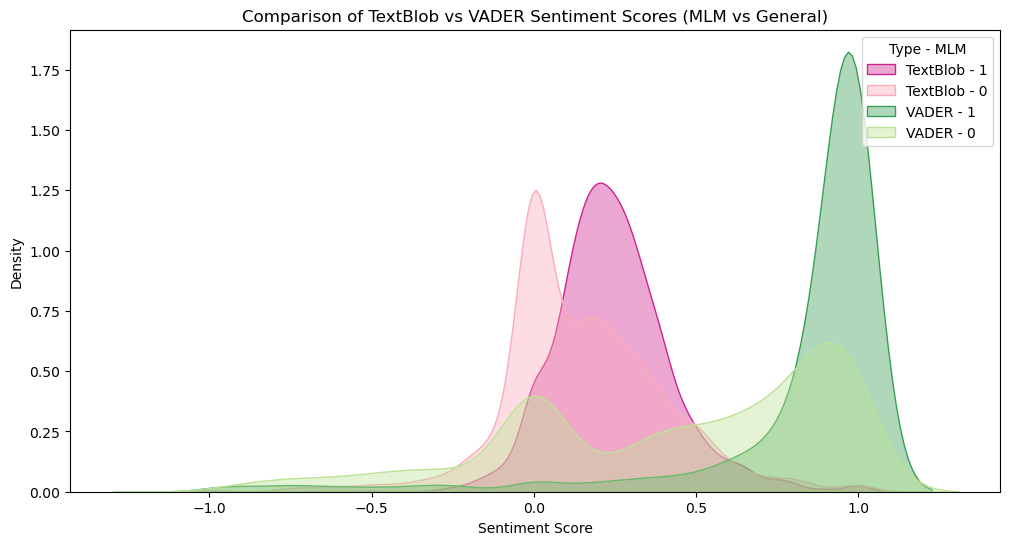

In [51]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=sentiment_df, x="textblob_polarity", hue="is_mlm", label="TextBlob", fill=True, alpha=0.4, palette="RdPu")
sns.kdeplot(data=sentiment_df, x="vader_compound", hue="is_mlm", label="VADER", fill=True, alpha=0.4, palette="YlGn")
plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.title("Comparison of TextBlob vs VADER Sentiment Scores (MLM vs General)")
plt.legend(title="Type - MLM", labels=['TextBlob - 1', 'TextBlob - 0', 'VADER - 1', 'VADER - 0'])
plt.show()

VADER better distinguishes MLM posts with stronger sentiment intensity, while TextBlob clusters more neutrally. We will further compare VADER against a RoBERTa transformer based sentiment analyser to see how they compare.

## Transformer based
[Twitter-roBERTa-base for Sentiment Analysis](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest) is a RoBERTa-base model trained on ~124M tweets from January 2018 to December 2021, and finetuned for sentiment analysis with the TweetEval benchmark. Given how long the instagrams posts in our dataset can be we will need to batch process them.

In [52]:
import torch
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from scipy.special import softmax

# RoBERTa twitter model
rt_model = "cardiffnlp/twitter-roberta-base-sentiment-latest"
roberta_twitter_tokenizer = AutoTokenizer.from_pretrained(rt_model)
roberta_config = AutoConfig.from_pretrained(rt_model)
roberta_twitter_sentiment_model = AutoModelForSequenceClassification.from_pretrained(rt_model)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [53]:
def get_roberta_sentiment(text_list):
    
    # Tokenise batch
    encoded_texts = roberta_twitter_tokenizer(
        text_list, return_tensors="pt", truncation=True, padding=True, max_length=512
    )

    # Model predictions
    with torch.no_grad():
        output = roberta_twitter_sentiment_model(**encoded_texts)

    # Convert logits to probabilities
    scores = softmax(output.logits.numpy(), axis=1)

    results = []
    for score in scores:
        roberta_neg, roberta_neu, roberta_pos = score[0], score[1], score[2]
        roberta_compound = (roberta_pos - roberta_neg) * (1 - roberta_neu)
        
        results.append({
            "roberta_neg": roberta_neg,
            "roberta_neu": roberta_neu,
            "roberta_pos": roberta_pos,
            "roberta_compound": roberta_compound
        })

    return results

# Batch process to prevent LongTensor problems
def batch_process_roberta(texts, batch_size=32):
    results = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Computing RoBERTa Sentiment"):
        batch_texts = texts[i : i + batch_size]  # Slice batch
        results.extend(get_roberta_sentiment(batch_texts))  # Process batch
    return results

In [54]:
# Batch process RoBERTa sentiment
roberta_results = batch_process_roberta(sentiment_df["cleaned_for_sentiment"].tolist())

# Merge
sentiment_df = sentiment_df.join(pd.DataFrame(roberta_results, index=sentiment_df.index))

sentiment_df

Computing RoBERTa Sentiment:   0%|          | 0/157 [00:00<?, ?it/s]

cleaned_for_sentiment  is_mlm  \
0     💡 Did you know - - what sets us apart from any...       1   
1     Share this with a biz bff or your stories to r...       1   
2     If you could scroll through our phones you'd b...       1   
3     Radiant Skin Starts Here 🌟 Give your skin the ...       1   
4     ✨ First winter glow update ! ✨ Today I noticed...       1   
...                                                 ...     ...   
4995  Upgrade your lawn game with the 42 Z6 Zero Tur...       0   
4996  Heating up the yard with our EGO Power Z6 zero...       0   
4997  Shop smarter , not harder with the App 🛒 💡 Use...       0   
4998  Absolutely loving our new Trillium greenhouse ...       0   
4999  Type 1 believes everyone and everything ... #c...       0   

      textblob_polarity  textblob_subjectivity  vader_pos  vader_neu  \
0              0.279524               0.675940      0.185      0.797   
1              0.200000               0.400000      0.268      0.732   
2              0.094792               0.316369      0.142      0.840   
3              0.296875               0.621429      0.178      0.822   
4              0.108933               0.539422      0.124      0.836   
...                 ...                    ...        ...        ...   
4995           0.250000               0.700000      0.193      0.744   
4996           0.337381               0.666190      0.226      0.735   
4997           0.050000               0.000000      0.394      0.606   
4998           0.382802               0.605032      0.166      0.834   
4999           0.000000               0.000000      0.000      1.000   

      vader_neg  vader_compound  roberta_neg  roberta_neu  roberta_pos  \
0         0.018          0.9897     0.002416     0.055272     0.942312   
1         0.000          0.8934     0.007428     0.416481     0.576092   
2         0.018          0.9493     0.003226     0.034833     0.961941   
3         0.000          0.9898     0.003006     0.044762     0.952232   
4         0.040          0.9516     0.004983     0.024271     0.970746   
...         ...             ...          ...          ...          ...   
4995      0.063          0.6588     0.003468     0.062084     0.934449   
4996      0.039          0.8858     0.002239     0.017785     0.979976   
4997      0.000          0.9552     0.002079     0.036021     0.961901   
4998      0.000          0.9482     0.002179     0.008360     0.989461   
4999      0.000          0.0000     0.103742     0.779291     0.116967   

      roberta_compound  
0             0.887947  
1             0.331827  
2             0.925320  
3             0.906737  
4             0.942323  
...                ...  
4995          0.873182  
4996          0.960348  
4997          0.925249  
4998          0.979029  
4999          0.002919  

[5000 rows x 12 columns]

### Compare VADER and RoBERTa

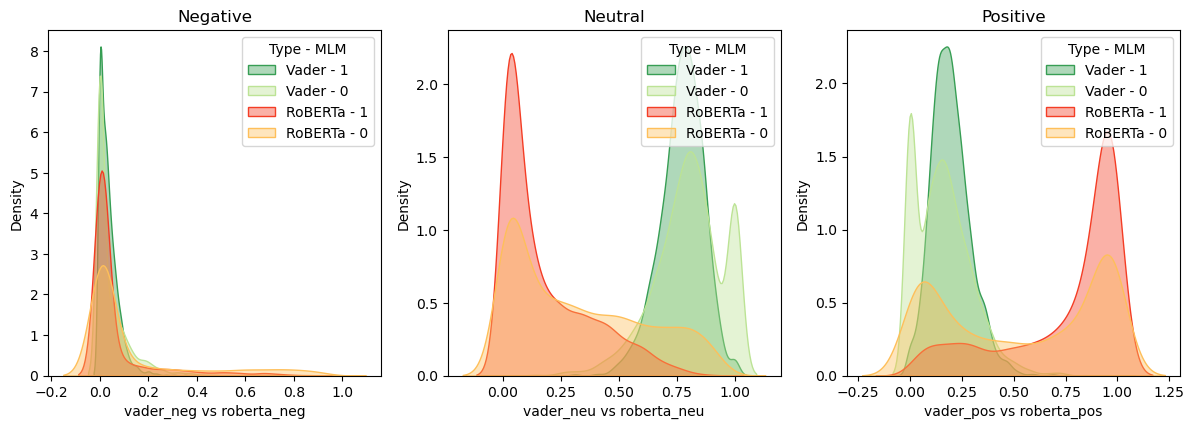

In [55]:
# Sentiment scores to compare
sentiment_pairs = [
    ("vader_neg", "roberta_neg"),
    ("vader_neu", "roberta_neu"),
    ("vader_pos", "roberta_pos")
]

labels = ["Negative", "Neutral", "Positive"]

plt.figure(figsize=(12, 8))

for i, (vader_col, roberta_col) in enumerate(sentiment_pairs, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(data=sentiment_df, x=vader_col, hue="is_mlm", fill=True, label="VADER", alpha=0.4, palette="YlGn")
    sns.kdeplot(data=sentiment_df, x=roberta_col, hue="is_mlm", fill=True, label="RoBERTa", alpha=0.4, palette="YlOrRd")
    plt.xlabel(vader_col + " vs " + roberta_col)
    plt.ylabel("Density")
    plt.title(labels[i-1])
    plt.legend(title="Type - MLM", labels=['Vader - 1', 'Vader - 0', 'RoBERTa - 1', 'RoBERTa - 0'])

plt.tight_layout()
plt.show()

RoBERTa offers a more varied and nuanced sentiment distribution, particularly in neutrality and positivity, whereas VADER tends to classify most posts as neutral which means it is less effective at distinguishing sentiment differences.

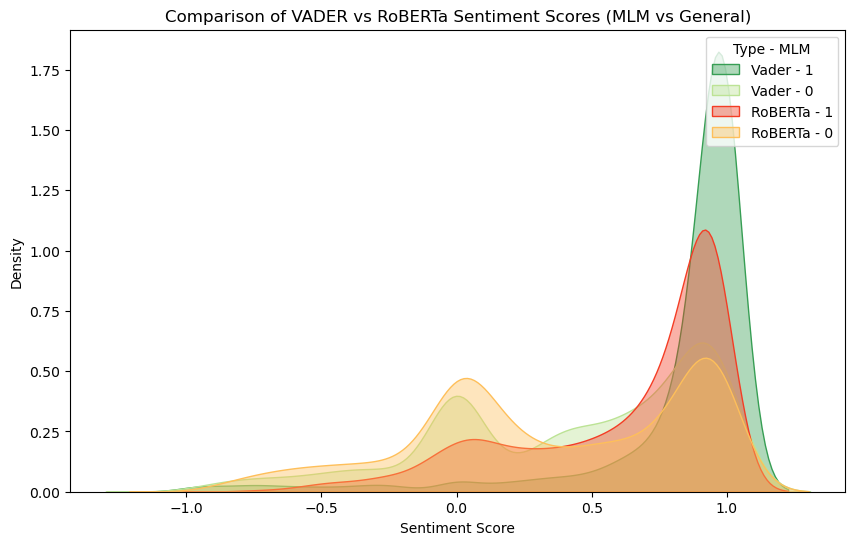

In [56]:
plt.figure(figsize=(10, 6))

# Compound scores
sns.kdeplot(data=sentiment_df, x="vader_compound", hue="is_mlm", fill=True, label="VADER", alpha=0.4, palette="YlGn")
sns.kdeplot(data=sentiment_df, x="roberta_compound", hue="is_mlm", fill=True, label="RoBERTa", alpha=0.4, palette="YlOrRd")

plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.title("Comparison of VADER vs RoBERTa Sentiment Scores (MLM vs General)")
plt.legend(title="Type - MLM", labels=['Vader - 1', 'Vader - 0', 'RoBERTa - 1', 'RoBERTa - 0'])
plt.show()


When comparing compound scores VADER’s assigns more extreme sentiment values, making MLM posts more clearly distinquishable, while RoBERTa maintains a more balanced distribution. This is likely due VADER applying boosting, dampening and negation, which don’t show up in its individual scores. 

Given that we will be using a single sentiment score as a feature in the feature dataset, and VADER distinguishes MLM posts with greater intensity, incorporates advanced heuristics, and is more computationally efficient, we will proceed with its compound score as the selected sentiment metric.

In [57]:
# Drop the 'sentiment' column if it exists before merging (avoid duplicates)
feature_df = feature_df.drop(columns=["sentiment"], errors="ignore")

# Merge VADER compound score into feature_df
feature_df = feature_df.merge(sentiment_df[['vader_compound']], left_index=True, right_index=True) \
                       .rename(columns={'vader_compound': 'sentiment'})

feature_df

is_mlm                                            content  word_count  \
0          1  "💡𝐃𝐢𝐝 𝐲𝐨𝐮 𝐤𝐧𝐨𝐰 —what sets us apart from any ot...         195   
1          1  "Share this with a biz bff or your stories to ...          29   
2          1  "If you could scroll through our phones you’d ...         113   
3          1  "Radiant Skin Starts Here 🌟\n\nGive your skin ...         187   
4          1  "✨ *First winter glow update!* ✨ \n\nToday I n...         156   
...      ...                                                ...         ...   
4995       0  "Upgrade your lawn game with the 42” Z6 Zero T...          23   
4996       0  "Heating up the yard with our @egopowerplus EG...          40   
4997       0  "Shop smarter, not harder with the @shopkick A...          30   
4998       0  "Absolutely loving our new Trillium greenhouse...          77   
4999       0  "Type 1 = believes everyone and everything….\n...          17   

      length  upper_char_count  upper_word_count  unicode_letter_count  \
0       1254                94                 6                  1021   
1        128                 2                 0                    88   
2        770                 8                 1                   629   
3       1121                50                 3                   869   
4        931                26                 7                   723   
...      ...               ...               ...                   ...   
4995     145                 7                 0                   107   
4996     218                 8                 1                   161   
4997     207                14                 0                   158   
4998     445                22                 3                   345   
4999     140                 1                 0                   109   

      unicode_word_count  emoji_count                       emojis_used  \
0                     44           11   💡, 🌿, 💧, 🧪, 💫, 🪞, ✅, ✅, ✅, ✨, 🔬   
1                      0            1                                 👇   
2                      0            1                                 🔥   
3                      0           11  🌟, 💧, 🌿, ✨, 🌸, 📦, 👉, 💕, 📲, 🌟, ⬇️   
4                      0            6                 ✨, ✨, 🧴, 💧, ❄️, ✨   
...                  ...          ...                               ...   
4995                   0            2                             🌿, 🇺🇸   
4996                   0            1                                🇺🇸   
4997                   0            3                           🛒, 💡, 🎁   
4998                   0            3                          🌿, ❤️, 💡   
4999                   0            0                                     

                 unique_emojis_used  hashtag_count  \
0         🧪, 💫, 💧, 🪞, ✅, 💡, ✨, 🔬, 🌿              9   
1                                 👇              0   
2                                 🔥             13   
3     💧, 📦, 📲, 👉, 🌟, 🌸, ✨, 💕, ⬇️, 🌿              8   
4                       ✨, 🧴, ❄️, 💧             10   
...                             ...            ...   
4995                          🇺🇸, 🌿              0   
4996                             🇺🇸              0   
4997                        💡, 🛒, 🎁              4   
4998                       ❤️, 💡, 🌿              0   
4999                                             9   

                                          hashtags_used  \
0     #JejuIslandBeauty, #GiantByoungpool, #KBeautyT...   
1                                                         
2     #gutreset, #guthealthy, #guthealthiseverything...   
3     #ForeverLiving, #SonyaSkincare, #AloeVeraCare,...   
4     #WinterGlow, #SkinCareJourney, #HealthySkin, #...   
...                                                 ...   
4995                                                      
4996                                                      
4997  #shopkick, #couponing, #Energizer, #EnergizerL...   
4998                        

In [58]:
# # Convert comma-separated emoji strings into proper lists, remove empty strings
# vector_df["emoji_list"] = vector_df["unique_emojis_used"].apply(
#     lambda x: [e for e in x.split(", ") if e] if isinstance(x, str) else []
# )

# # MultiLabelBinarizer
# mlb = MultiLabelBinarizer(classes=sorted(emoji.EMOJI_DATA.keys()))

# # One-hot encoding
# X_emoji_onehot = mlb.fit_transform(vector_df["emoji_list"])

# # Make df
# emoji_onehot_df = pd.DataFrame(X_emoji_onehot, columns=mlb.classes_)

# emoji_onehot_df

# Classical models
Drop columns that will not be vectorised (converted into numerical forms) for machine learning. The untokenised content, repeated columns (emojis, hashtags), those geared towards sentiment analysis, and ones that showed little significance during data analysis are removed.

In [59]:
# Remove features that will not be vectorised
vector_df = feature_df.copy()
vector_df = vector_df.drop(columns=["content", "emojis_used", "hashtags_used", "unique_emojis_used", "unicode_word_count"], axis=1, errors="ignore")
vector_df.head(5)

is_mlm  word_count  length  upper_char_count  upper_word_count  \
0       1         195    1254                94                 6   
1       1          29     128                 2                 0   
2       1         113     770                 8                 1   
3       1         187    1121                50                 3   
4       1         156     931                26                 7   

   unicode_letter_count  emoji_count  hashtag_count  \
0                  1021           11              9   
1                    88            1              0   
2                   629            1             13   
3                   869           11              8   
4                   723            6             10   

                               cleaned_for_sentiment  \
0  💡 Did you know - - what sets us apart from any...   
1  Share this with a biz bff or your stories to r...   
2  If you could scroll through our phones you'd b...   
3  Radiant Skin Starts Here 🌟 Give your skin the ...   
4  ✨ First winter glow update ! ✨ Today I noticed...   

                                      cleaned_for_ml  sentiment  
0  💡 know - set u apart brand market ? skincare p...     0.9897  
1  share biz bff story remind capable . one fav 1...     0.8934  
2  could scroll phone inspired constant winstesti...     0.9493  
3  radiant skin starts 🌟 give skin care deserves ...     0.9898  
4  ✨ first winter glow update ! ✨ today noticed b...     0.9516

## Vectorisation

In [60]:
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import StandardScaler

# Numeric features
X_numeric = vector_df.drop(columns=["cleaned_for_sentiment", "cleaned_for_ml", "is_mlm"], errors="ignore")

# Convert X_numeric to a sparse matrix (For BoW and TF-IDF)
X_numeric_sparse = csr_matrix(X_numeric.values)

def stack_vectors_with_numeric_features(vectors, method, sparse=False):
    print(f"{method} shape: ", vectors.shape)
    if sparse:
        stacked_vectors = hstack([csr_matrix(vectors), X_numeric_sparse])
    else:
        # Stack dense text vectors with numeric features
        stacked_vectors = np.hstack([vectors, X_numeric.values])
        
        # Apply StandardScaler (prevent max iteration error)
        stacked_vectors = StandardScaler().fit_transform(stacked_vectors)

    print(f"{method} stacked shape: ", stacked_vectors.shape)
    return stacked_vectors

### Bag of Words (BoW)

In [61]:
# Initialise
bow_vectorizer = CountVectorizer(max_features=5000)

# Transform
X_text_bow = bow_vectorizer.fit_transform(vector_df["cleaned_for_ml"])

# Stack with numeric features
X_bow = stack_vectors_with_numeric_features(X_text_bow, "BoW", sparse=True)

BoW shape:  (5000, 5000)
BoW stacked shape:  (5000, 5008)


### TF-IDF

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialise
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Transform
X_text_tfidf = tfidf_vectorizer.fit_transform(vector_df["cleaned_for_ml"])

# Stack with numeric features
X_tfidf = stack_vectors_with_numeric_features(X_text_tfidf, "TF-IDF", sparse=True)

TF-IDF shape:  (5000, 5000)
TF-IDF stacked shape:  (5000, 5008)


### Word embeddings

In [63]:
# Use less processed text for word embeddings
embedding_column = vector_df["cleaned_for_sentiment"]

# Tokeniser
def custom_tokenise_text_demojize(text):
    text_demojized_lowered = emoji.demojize(text.lower(), delimiters=(" ", " "))
    return CustomTweetTokenizer().tokenize(text_demojized_lowered)

def custom_tokenise_text(text):
    return CustomTweetTokenizer().tokenize(text.lower())

#### GloVe

In [64]:
import gensim
from gensim.models import KeyedVectors

# Load pretrained GloVe embeddings
glove_model =  KeyedVectors.load_word2vec_format("./glove.6B.300d.txt", no_header=True)

def get_glove_embedding(text):
    tokens = custom_tokenise_text_demojize(text)
    embeddings = [glove_model[word] for word in tokens if word in glove_model]

    # Ensure it returns a 300D vector
    return np.mean(embeddings, axis=0) if embeddings else np.zeros((300,))


# Apply embeddings
tqdm.pandas(desc="Processing GloVe embeddings")
X_text_glove = np.vstack(embedding_column.progress_apply(get_glove_embedding))

# Stack with numeric features
X_glove = stack_vectors_with_numeric_features(X_text_glove, "GloVe")

Processing GloVe embeddings:   0%|          | 0/5000 [00:00<?, ?it/s]

GloVe shape:  (5000, 300)
GloVe stacked shape:  (5000, 308)


#### Word2Vec

In [65]:
# Load Pretrained Word2Vec
word2vec_model = KeyedVectors.load_word2vec_format("./GoogleNews-vectors-negative300.bin", binary=True)

# Get average word embedding
def get_word2vec_embedding(text):
    tokens = custom_tokenise_text_demojize(text)
    embeddings = [word2vec_model[word] for word in tokens if word in word2vec_model]
    
    # Ensure it returns a 300D vector
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(300,)

# Apply embeddings to all tokenised text
tqdm.pandas(desc="Processing Word2Vec embeddings")
X_text_w2v = np.vstack(embedding_column.progress_apply(get_word2vec_embedding))

# Stack with numeric features
X_w2v = stack_vectors_with_numeric_features(X_text_w2v, "Word2Vec")

Processing Word2Vec embeddings:   0%|          | 0/5000 [00:00<?, ?it/s]

Word2Vec shape:  (5000, 300)
Word2Vec stacked shape:  (5000, 308)


#### FastText

In [66]:
import fasttext

# Load FastText embeddings
fasttext_model = fasttext.load_model('./cc.en.300.bin')

# Get FastText embedding
def get_fasttext_embedding(text):
    tokens = custom_tokenise_text(text)
    embeddings = [fasttext_model.get_word_vector(word) for word in tokens]

    # Ensure it returns a 300D vector
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(300, )

tqdm.pandas(desc="Processing FastText embeddings")
X_text_fasttext = np.vstack(embedding_column.progress_apply(get_fasttext_embedding))

# Stack with numeric features
X_fasttext = stack_vectors_with_numeric_features(X_text_fasttext, "FastText")

Processing FastText embeddings:   0%|          | 0/5000 [00:00<?, ?it/s]

FastText shape:  (5000, 300)
FastText stacked shape:  (5000, 308)


## Comparing classical models

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
from tabulate import tabulate
from IPython.display import display, HTML

# Target variable
y = vector_df["is_mlm"]

vectorization_methods = {
    "BoW": X_bow,
    "TF-IDF": X_tfidf,
    "Word2Vec": X_w2v,
    "GloVe": X_glove,
    "FastText": X_fasttext
}

def train_validate_evaluate(X_full, model, model_name, vectorization_name):

    # Split into training (80%) and temp (20%)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_full, y, stratify=y, test_size=0.2, random_state=42
    )

    # Split temp into validation (10%) and test (10%)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=42
    )

    # Train model
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    report = classification_report(y_test, y_test_pred, output_dict=True)
    
    results = {
        "Model": model_name,
        "Vectorization": vectorization_name,
        "Validation Accuracy": round(val_accuracy, 4),
        "Test Accuracy": round(test_accuracy, 4),
        "Precision (0)": round(report["0"]["precision"], 4),
        "Recall (0)": round(report["0"]["recall"], 4),
        "F1-Score (0)": round(report["0"]["f1-score"], 4),
        "Precision (1)": round(report["1"]["precision"], 4),
        "Recall (1)": round(report["1"]["recall"], 4),
        "F1-Score (1)": round(report["1"]["f1-score"], 4)
    }

    return model, results

### Logistic regression

In [68]:
from sklearn.linear_model import LogisticRegression

# Initialise model
model = LogisticRegression(max_iter=5000)
model_name = "Logistic Regression"

lr_res = []

# Train and evaluate
for vectorization_method_name, X_vectors in tqdm(vectorization_methods.items(), desc="Training Models", unit="model"):
    model, results = train_validate_evaluate(X_vectors, model, model_name, vectorization_method_name)
    lr_res.append(results)

lr_res_df = pd.DataFrame(lr_res)
display(HTML(lr_res_df.to_html(index=False)))

Training Models:   0%|          | 0/5 [00:00<?, ?model/s]

### Support vector machine

In [69]:
from sklearn.svm import SVC

# Initialise model
model = SVC(random_state=42)
model_name = "SVM (Linear)"

svm_res = []

# Train and evaluate for each vectorization method
for vectorization_method_name, X_vectors in tqdm(vectorization_methods.items(), desc="Training SVM Models", unit="model"):
    model, results = train_validate_evaluate(X_vectors, model, model_name, vectorization_method_name)
    svm_res.append(results)

svm_res_df = pd.DataFrame(svm_res)
display(HTML(svm_res_df.to_html(index=False)))

Training SVM Models:   0%|          | 0/5 [00:00<?, ?model/s]

### Random Forest

In [70]:
from sklearn.ensemble import RandomForestClassifier

# Initialise model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model_name = "Random Forest"

rf_res = []

# Train and evaluate for each vectorization method
for vectorization_method_name, X_vectors in tqdm(vectorization_methods.items(), desc="Training Random Forest Models", unit="model"):
    model, results = train_validate_evaluate(X_vectors, model, model_name, vectorization_method_name)
    rf_res.append(results)

rf_res_df = pd.DataFrame(rf_res)
display(HTML(rf_res_df.to_html(index=False)))

Training Random Forest Models:   0%|          | 0/5 [00:00<?, ?model/s]

### XGBoost

In [71]:
from xgboost import XGBClassifier

# Initialise model
model = XGBClassifier(eval_metric="logloss", random_state=42)
model_name = "XGBoost"

xg_res = []

# Train and evaluate
for vectorization_method_name, X_vectors in tqdm(vectorization_methods.items(), desc="Training XGBoost Models", unit="model"):
    model, results = train_validate_evaluate(X_vectors, model, model_name, vectorization_method_name)
    xg_res.append(results)

xg_res_df = pd.DataFrame(xg_res)
display(HTML(xg_res_df.to_html(index=False)))

Training XGBoost Models:   0%|          | 0/5 [00:00<?, ?model/s]

## Results

In [72]:
# Concatenate all results
combined_results_df = pd.concat([lr_res_df, svm_res_df, rf_res_df, xg_res_df], ignore_index=True)

combined_results_df

Model Vectorization  Validation Accuracy  Test Accuracy  \
0   Logistic Regression           BoW                0.948          0.944   
1   Logistic Regression        TF-IDF                0.914          0.920   
2   Logistic Regression      Word2Vec                0.868          0.868   
3   Logistic Regression         GloVe                0.866          0.884   
4   Logistic Regression      FastText                0.904          0.872   
5          SVM (Linear)           BoW                0.782          0.766   
6          SVM (Linear)        TF-IDF                0.782          0.766   
7          SVM (Linear)      Word2Vec                0.892          0.908   
8          SVM (Linear)         GloVe                0.908          0.892   
9          SVM (Linear)      FastText                0.918          0.884   
10        Random Forest           BoW                0.882          0.894   
11        Random Forest        TF-IDF                0.878          0.896   
12        Random Forest      Word2Vec                0.878          0.866   
13        Random Forest         GloVe                0.882          0.856   
14        Random Forest      FastText                0.880          0.860   
15              XGBoost           BoW                0.916          0.922   
16              XGBoost        TF-IDF                0.932          0.916   
17              XGBoost      Word2Vec                0.908          0.896   
18              XGBoost         GloVe                0.912          0.888   
19              XGBoost      FastText                0.902          0.886   

    Precision (0)  Recall (0)  F1-Score (0)  Precision (1)  Recall (1)  \
0          0.9302       0.960        0.9449         0.9587       0.928   
1          0.9102       0.932        0.9209         0.9303       0.908   
2          0.9000       0.828        0.8625         0.8407       0.908   
3          0.9211       0.840        0.8787         0.8529       0.928   
4          0.9152       0.820        0.8650         0.8370       0.924   
5          0.8122       0.692        0.7473         0.7317       0.840   
6          0.8122       0.692        0.7473         0.7317       0.840   
7          0.9359       0.876        0.9050         0.8835       0.940   
8          0.9261       0.852        0.8875         0.8630       0.932   
9          0.9248       0.836        0.8782         0.8504       0.932   
10         0.9339       0.848        0.8889         0.8608       0.940   
11         0.9267       0.860        0.8921         0.8694       0.932   
12         0.8797       0.848        0.8635         0.8533       0.884   
13         0.8771       0.828        0.8519         0.8371       0.884   
14         0.8782       0.836        0.8566         0.8435       0.884   
15         0.9170       0.928        0.9225         0.9271       0.916   
16         0.9262       0.904        0.9150         0.9062       0.928   
17         0.9267       0.860        0.8921         0.8694       0.932   
18         0.9076       0.864        0.8852         0.8702       0.912   
19         0.9072       0.860        0.8830         0.8669       0.912   

    F1-Score (1)  
0         0.9431  
1         0.9190  
2         0.8731  
3         0.8889  
4         0.8783  
5         0.7821  
6         0.7821  
7         0.9109  
8         0.8962  
9         0.8893  
10        0.8987  
11        0.8996  
12        0.8684  
13        0.8599  
14        0.8633  
15        0.9215  
16        0.9170  
17        0.8996  
18        0.8906  
19        0.8889

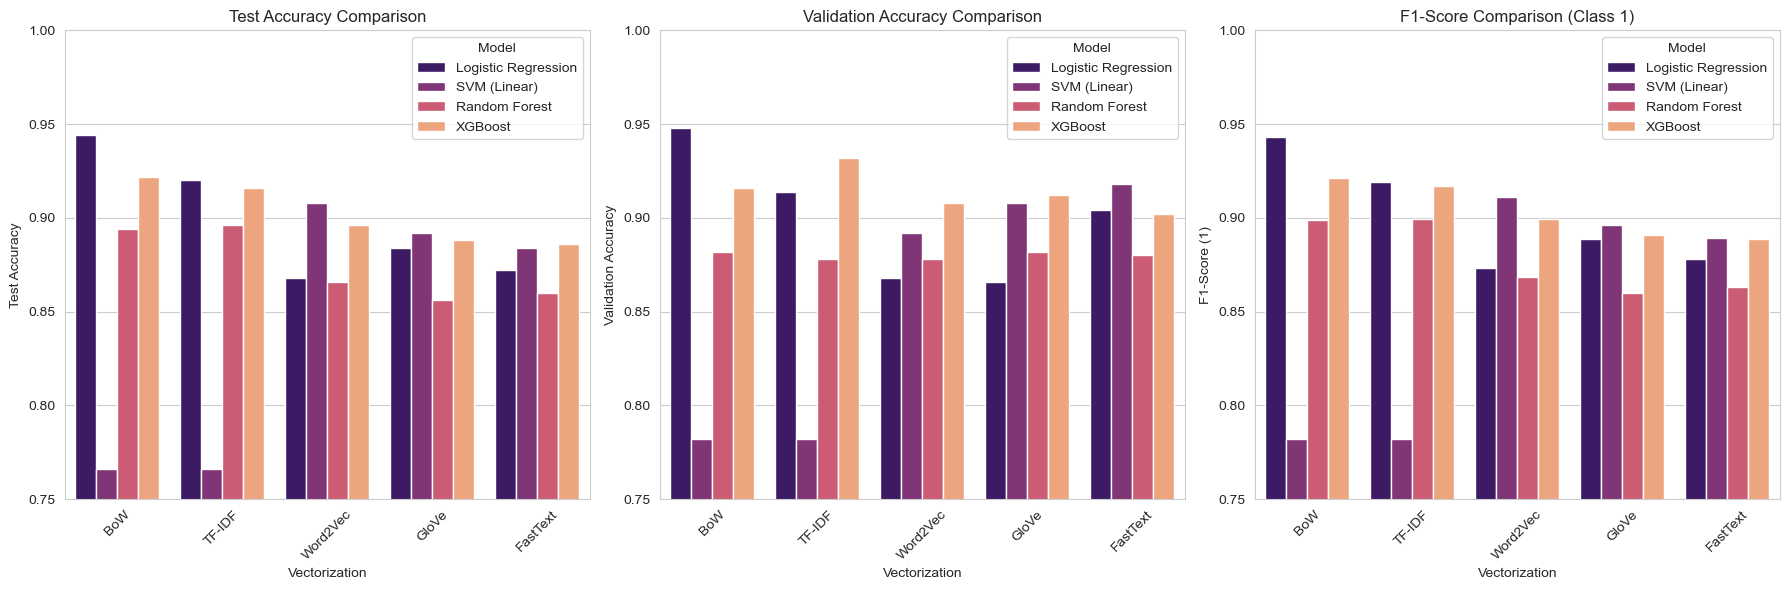

In [73]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
y_limits = (0.75, 1.0)

# Accuracy
sns.barplot(data=combined_results_df, x="Vectorization", y="Test Accuracy", hue="Model", ax=axes[0], palette="magma")
axes[0].set_title("Test Accuracy Comparison")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_ylim(y_limits)

# Validation Accuracy
sns.barplot(data=combined_results_df, x="Vectorization", y="Validation Accuracy", hue="Model", ax=axes[1], palette="magma")
axes[1].set_title("Validation Accuracy Comparison")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_ylim(y_limits)

# F1-Score
sns.barplot(data=combined_results_df, x="Vectorization", y="F1-Score (1)", hue="Model", ax=axes[2], palette="magma")
axes[2].set_title("F1-Score Comparison (Class 1)")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)
axes[2].set_ylim(y_limits)

plt.tight_layout()
plt.show()

Bag of Words far outperforms the other vectorisation methods overall with an accuracy of 94.4% in a Logistic Regression model, likely because it directly preserves the frequency of individual words. This indicates that MLM posts contain specific terminology that uniquely identifies them. More complicated vectorisers that introduce weights and context might diminish the importance of these words.

# Baseline Model
Logistic regression with Bag of Words vectorisation

In [74]:
# Split into training (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_bow, y, stratify=y, test_size=0.2, random_state=42
)

# Split temp into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=42
)

# Train model
model = LogisticRegression(max_iter=5000).fit(X_train, y_train)

# Validation
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Test
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]
test_accuracy = accuracy_score(y_test, y_test_pred)

report = classification_report(y_test, y_test_pred)

print("Logistic Regression with BoW Tokeniser:\n")
print(report)

Logistic Regression with BoW Tokeniser:

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       250
           1       0.96      0.93      0.94       250

    accuracy                           0.94       500
   macro avg       0.94      0.94      0.94       500
weighted avg       0.94      0.94      0.94       500



In [75]:
baseline_results = {
    "Model": "Baseline (LogReg + BoW)",
    "eval_loss": 'N/A',
    "eval_model_preparation_time": 'N/A',
    "eval_accuracy": test_accuracy,
    "eval_precision": precision_score(y_test, y_test_pred),
    "eval_recall": recall_score(y_test, y_test_pred),
    "eval_f1": f1_score(y_test, y_test_pred),
    "eval_runtime": 'N/A',
    "eval_samples_per_second": 'N/A',
    "eval_steps_per_second": 'N/A',
}


baseline_results_df = pd.DataFrame([baseline_results])
baseline_results_df

Model eval_loss eval_model_preparation_time  \
0  Baseline (LogReg + BoW)       N/A                         N/A   

   eval_accuracy  eval_precision  eval_recall   eval_f1 eval_runtime  \
0          0.944        0.958678        0.928  0.943089          N/A   

  eval_samples_per_second eval_steps_per_second  
0                     N/A                   N/A

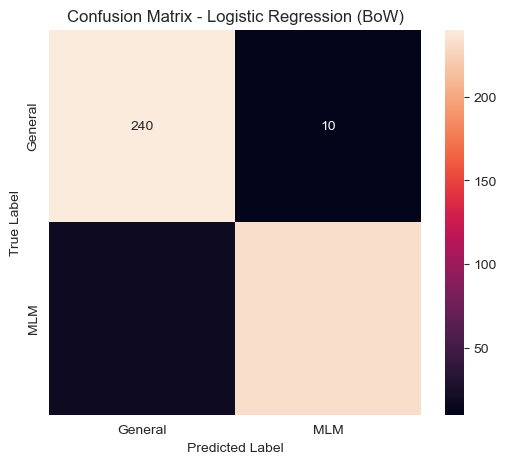

In [76]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=["General", "MLM"], yticklabels=["General", "MLM"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression (BoW)")
plt.show()

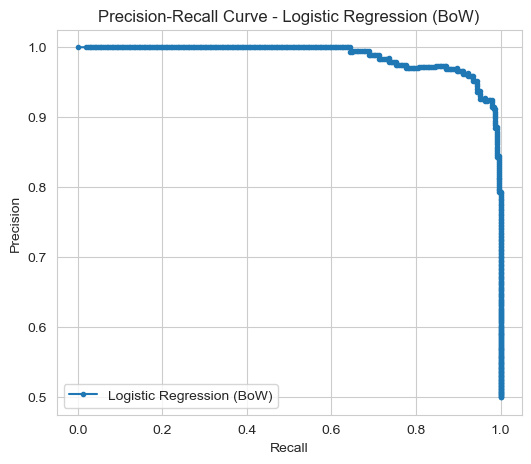

In [77]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, marker=".", label="Logistic Regression (BoW)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression (BoW)")
plt.legend()
plt.show()

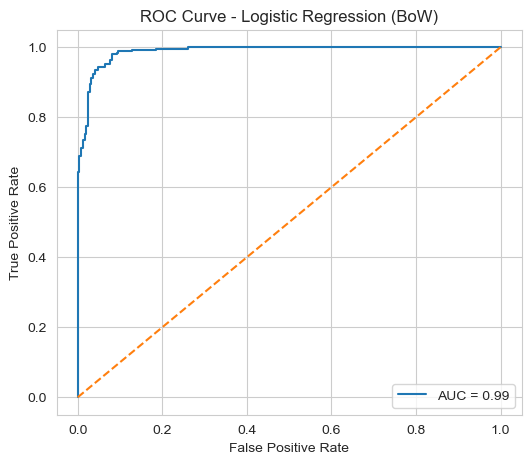

In [78]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (BoW)")
plt.legend()
plt.show()

# Transformer based models

In [96]:
import os
from pathlib import Path
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(evaluation_predictions):
    predictions, labels = evaluation_predictions
    predictions = predictions.argmax(axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [128]:
def tokenise_transformer_model(model_name):
    # Load tokeniser
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    def tokenise_function(example):
        return tokenizer(example["text"], truncation=True, padding="max_length")
    
    df = vector_df[["cleaned_for_sentiment", "is_mlm"]].rename(columns={"is_mlm": "label"})
    
    # Split the data into training, temporary (for validation and test) sets.
    train_texts, temp_texts, train_labels, temp_labels = train_test_split(
        df["cleaned_for_sentiment"],
        df["label"],
        test_size=0.2,
        stratify=df["label"],
        random_state=42
    )
    
    # Split the temporary set equally into validation and test sets.
    val_texts, test_texts, val_labels, test_labels = train_test_split(
        temp_texts,
        temp_labels,
        test_size=0.5,
        stratify=temp_labels,
        random_state=42
    )
    
    # Create Hugging Face datasets from the lists
    train_dataset = Dataset.from_dict({"text": train_texts.tolist(), "label": train_labels.tolist()})
    val_dataset = Dataset.from_dict({"text": val_texts.tolist(), "label": val_labels.tolist()})
    test_dataset = Dataset.from_dict({"text": test_texts.tolist(), "label": test_labels.tolist()})
    
    # Tokenise the datasets
    train_dataset = train_dataset.map(tokenise_function, batched=True)
    val_dataset = val_dataset.map(tokenise_function, batched=True)
    test_dataset = test_dataset.map(tokenise_function, batched=True)
    
    return train_dataset, val_dataset, test_dataset


def train_transformer_model(model_name, train_dataset, val_dataset):
    # Saved checkpoints
    output_dir = f"./results/{model_name}"
    
    # Check if checkpoint already exists
    last_checkpoint = None
    if os.path.isdir(output_dir):
        checkpoints = list(Path(output_dir).glob("checkpoint-*"))
        if checkpoints:
            last_checkpoint = max(checkpoints, key=lambda x: int(x.name.split("-")[-1]))
            print(f"Found checkpoint {last_checkpoint}, resuming training from there.")
    
    # Load the model. If a checkpoint exists, load from it; otherwise, load the pretrained model.
    model = AutoModelForSequenceClassification.from_pretrained(
        last_checkpoint if last_checkpoint else model_name, num_labels=2
    )
    
    # Training args
    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        logging_dir=f"./logs/{model_name}",
        logging_steps=500,
        save_strategy="epoch",
        load_best_model_at_end=True,
    )
    
    # Initialise the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
    )
    
    # Train the model return the best
    trainer.train(resume_from_checkpoint=last_checkpoint)
    best_checkpoint = trainer.state.best_model_checkpoint
    return best_checkpoint


def evaluate_model(model_name, best_checkpoint, test_dataset, compute_metrics):
    # Load the model from the checkpoint if available; otherwise, load the original model.
    model = AutoModelForSequenceClassification.from_pretrained(
        best_checkpoint, num_labels=2
    )
    
    # Create minimal training arguments for evaluation
    training_args = TrainingArguments(
        output_dir=f"./results/{model_name}",
        eval_strategy="epoch",
        per_device_eval_batch_size=8,
        logging_dir=f"./logs/{model_name}",
    )
    
    # Initialise the Trainer with the evaluation dataset and compute_metrics
    trainer = Trainer(
        model=model,
        args=training_args,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
    )
    
    # Evaluate the model
    evaluation_results = trainer.evaluate(test_dataset)
    
    print("Evaluation results:")
    for key, value in evaluation_results.items():
        print(f"{key}: {value:.4f}")
    
    return evaluation_results

## Electra

In [134]:
model_name = "google/electra-base-discriminator"

train_dataset, val_dataset, test_dataset = tokenise_transformer_model(model_name)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [135]:
electra_best_model = train_transformer_model(model_name, train_dataset, val_dataset)

Found checkpoint results/google/electra-base-discriminator/checkpoint-1500, resuming training from there.


In [136]:
electra_results=evaluate_model(model_name, electra_best_model, test_dataset, compute_metrics)

Evaluation results:
eval_loss: 0.2320
eval_model_preparation_time: 0.0009
eval_accuracy: 0.9420
eval_precision: 0.9458
eval_recall: 0.9420
eval_f1: 0.9419
eval_runtime: 18.3726
eval_samples_per_second: 27.2140
eval_steps_per_second: 3.4290


In [127]:
electra_results["Model"] = "ELECTRA"
electra_results_df = pd.DataFrame([electra_results])
electra_results_df

eval_loss  eval_model_preparation_time  eval_accuracy  eval_precision  \
0   0.231996                       0.0009          0.942        0.945773   

   eval_recall   eval_f1  eval_runtime  eval_samples_per_second  \
0        0.942  0.941877       18.2243                   27.436   

   eval_steps_per_second    Model  
0                  3.457  ELECTRA

## Bert

In [137]:
model_name = "bert-base-uncased"

train_dataset, val_dataset, test_dataset = tokenise_transformer_model(model_name)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [138]:
bert_best_model = train_transformer_model(model_name, train_dataset, val_dataset)

Found checkpoint results/bert-base-uncased/checkpoint-1500, resuming training from there.


In [139]:
bert_results=evaluate_model(model_name, bert_best_model, test_dataset, compute_metrics)

Evaluation results:
eval_loss: 0.2229
eval_model_preparation_time: 0.0009
eval_accuracy: 0.9480
eval_precision: 0.9481
eval_recall: 0.9480
eval_f1: 0.9480
eval_runtime: 21.4608
eval_samples_per_second: 23.2980
eval_steps_per_second: 2.9360


In [90]:
bert_results["Model"] = "BERT"
bert_results_df = pd.DataFrame([bert_results])
bert_results_df

eval_loss  eval_model_preparation_time  eval_accuracy  eval_precision  \
0   0.283661                        0.001           0.96        0.960265   

   eval_recall   eval_f1  eval_runtime  eval_samples_per_second  \
0         0.96  0.959994       21.7322                   23.007   

   eval_steps_per_second Model  
0                  2.899  BERT

## RoBERTa

In [140]:
model_name = "roberta-base"

train_dataset, val_dataset, test_dataset = tokenise_transformer_model(model_name)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [141]:
roberta_best_model = train_transformer_model(model_name, train_dataset, val_dataset)

Found checkpoint results/roberta-base/checkpoint-1500, resuming training from there.


In [142]:
roberta_results=evaluate_model(model_name, roberta_best_model, test_dataset, compute_metrics)

Evaluation results:
eval_loss: 0.3481
eval_model_preparation_time: 0.0009
eval_accuracy: 0.9320
eval_precision: 0.9338
eval_recall: 0.9320
eval_f1: 0.9319
eval_runtime: 21.3520
eval_samples_per_second: 23.4170
eval_steps_per_second: 2.9510


In [143]:
roberta_results["Model"] = "RoBERTa"
roberta_results_df = pd.DataFrame([roberta_results])
roberta_results_df

eval_loss  eval_model_preparation_time  eval_accuracy  eval_precision  \
0   0.348067                       0.0009          0.932        0.933777   

   eval_recall  eval_f1  eval_runtime  eval_samples_per_second  \
0        0.932  0.93193        21.352                   23.417   

   eval_steps_per_second    Model  
0                  2.951  RoBERTa

## DistilBERT

In [144]:
model_name = "distilbert-base-uncased"

train_dataset, val_dataset, test_dataset = tokenise_transformer_model(model_name)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [147]:
distilbert_best_model = train_transformer_model(model_name, train_dataset, val_dataset)

Found checkpoint results/distilbert-base-uncased/checkpoint-1500, resuming training from there.


In [148]:
distilbert_results=evaluate_model(model_name, distilbert_best_model, test_dataset, compute_metrics)

Evaluation results:
eval_loss: 0.1883
eval_model_preparation_time: 0.0004
eval_accuracy: 0.9520
eval_precision: 0.9527
eval_recall: 0.9520
eval_f1: 0.9520
eval_runtime: 10.9943
eval_samples_per_second: 45.4780
eval_steps_per_second: 5.7300


In [111]:
distilbert_results["Model"] = "DistilBERT"
distilbert_results_df = pd.DataFrame([distilbert_results])
distilbert_results_df

eval_loss  eval_model_preparation_time  eval_accuracy  eval_precision  \
0   0.203961                       0.0004          0.954        0.954881   

   eval_recall   eval_f1  eval_runtime  eval_samples_per_second  \
0        0.954  0.953978       11.0312                   45.326   

   eval_steps_per_second       Model  
0                  5.711  DistilBERT

In [149]:
# Concatenate all results
combined_results_df = pd.concat(
    [baseline_results_df, electra_results_df, bert_results_df, roberta_results_df, distilbert_results_df],
    ignore_index=True).dropna(axis=1, how="all")

# Re-order
combined_results_df = combined_results_df[["Model"] + [col for col in electra_results_df.columns if col != "Model"]]

combined_results_df

Model eval_loss eval_model_preparation_time  \
0  Baseline (LogReg + BoW)       N/A                         N/A   
1                  ELECTRA  0.231996                      0.0009   
2                     BERT  0.283661                       0.001   
3                  RoBERTa  0.348067                      0.0009   
4               DistilBERT  0.203961                      0.0004   

   eval_accuracy  eval_precision  eval_recall   eval_f1 eval_runtime  \
0          0.944        0.958678        0.928  0.943089          N/A   
1          0.942        0.945773        0.942  0.941877      18.2243   
2          0.960        0.960265        0.960  0.959994      21.7322   
3          0.932        0.933777        0.932  0.931930       21.352   
4          0.954        0.954881        0.954  0.953978      11.0312   

  eval_samples_per_second eval_steps_per_second  
0                     N/A                   N/A  
1                  27.436                 3.457  
2                  23.007                 2.899  
3                  23.417                 2.951  
4                  45.326                 5.711

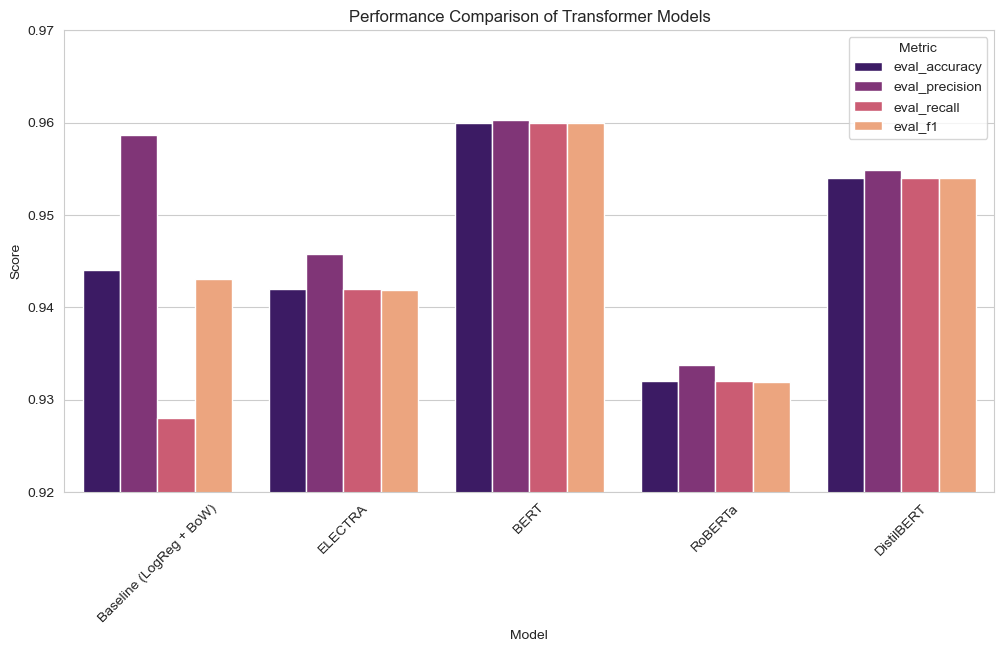

In [150]:
# Performance comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=combined_results_df.melt(id_vars=["Model"],
    var_name="Metric",
    value_name="Score",
    value_vars=["eval_accuracy", "eval_precision", "eval_recall", "eval_f1"]),
    x="Model",
    y="Score",
    hue="Metric",
    palette="magma")

plt.title("Performance Comparison of Transformer Models")
plt.xlabel("Model")
plt.ylabel("Score")
plt.ylim(0.92, 0.97)
plt.legend(title="Metric")
plt.xticks(rotation=45)
plt.show()

The first time we ran the transformer models Electra achieved the highest accuracy (95.6%) and F1-score, likely due to its focus on replaced token detection rather than standard masked language modeling. Despite being a smaller model, DistilBERT came close to BERT and Electra in performance, which suggests that MLM posts rely heavily on repetitive/straightforward language, i.e. heavy model complexity is less necessary. However after losing the Jupyter notebook state and re-running the transformers with the saved checkpoints BERT achieved the highest accuracy with 96%, DistilBERT was a close second with 95.4%. These differences likely stem from inherent randomness (e.g., in weight initialisation and dropout) and even when using the best saved checkpoint, these factors can lead to minor shifts in performance metrics.

The baseline logistic regression with a Bag-of-Words representation remains remarkably competitive. Simple word frequencies appear to carry substantial predictive power and considering its efficiency this method might be the most cost-effective choice, striking a favourable balance between power usage and overall accuracy.

We will next try hyperparameter tuning to boost BERT scores, if we can increase them enough perhaps the efficiency will be worth the increased power consumption.

In [152]:
transformer_model = AutoModelForSequenceClassification.from_pretrained(bert_best_model, num_labels=2)

# Save the BERT model
transformer_model.save_pretrained('./models/trained_bert_model')

## Hyperparameter tuning
We opted for Optuna over a traditional grid search because grid search exhaustively tests every combination of parameters, which can be very inefficient and computationally expensive. Optuna however uses an adaptive sampling strategy that quickly hones in on the most promising hyperparameter regions which allows us to achieve optimal performance with fewer trials and less overhead.

In [165]:
import optuna

# Optuna hyperparameter search space
def tuneBERT(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 4),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16]),
        "weight_decay": trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
    }

In [168]:
# Best performing model without tuning
model_name = "bert-base-uncased"

# Test train split
train_dataset, val_dataset, test_dataset = tokenise_transformer_model(model_name)

# Define model_init to return a new instance of model for each trial
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Training args
training_args = TrainingArguments(
    output_dir="./results/bert_tuned",
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,  # will be tuned
    per_device_train_batch_size=8,  # will be tuned
    per_device_eval_batch_size=8,
    num_train_epochs=3,  # will be tuned
    weight_decay=0.01,  # will be tuned
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="none",
)

# Trainer
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Run hyperparameter search with Optuna
best_trial = trainer.hyperparameter_search(
    hp_space=tuneBERT,
    n_trials=10,
    direction="maximize",
    compute_objective=lambda metrics: metrics["eval_accuracy"],
    backend="optuna"
)


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-03-16 15:11:13,845] A new study created in memory with name: no-name-a2b4f463-dba9-414e-a9ac-e30958832167
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-03-16 15:37:43,428] Trial 0 finished with value: 0.982 and parameters: {'learning_rate': 1.8301720554967784e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 1.8361534822064063e-05}. Best is trial 0 with value: 0.982.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-03-16 16:04:05,409] Trial 1 finished with value: 0.98 and parameters: {'learning_rate': 1.2214475327502185e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.00032819425766314654}. Best is trial 0 with value: 0.982.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-03-16 16:39:13,074] Trial 2 finished with value: 0.976 and parameters: {'learning_rate': 1.5150326699642817e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.008737127071573387}. Best is trial 0 with value: 0.982.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-03-16 17:06:34,140] Trial 3 finished with value: 0.98 and parameters: {'learning_rate': 1.2819001679110981e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 4.70928563565019e-05}. Best is trial 0 with value: 0.982.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-03-16 17:33:44,607] Trial 4 finished with value: 0.982 and parameters: {'learning_rate': 2.6269422539358756e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 3.514221749410317e-05}. Best is trial 0 with value: 0.982.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-03-16 18:00:09,368] Trial 5 finished with value: 0.98 and parameters: {'learning_rate': 1.6510156706189416e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.001242965919361708}. Best is trial 0 with value: 0.982.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-03-16 18:08:44,711] Trial 6 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-03-16 18:17:33,537] Trial 7 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-03-16 18:44:03,957] Trial 8 finished with value: 0.984 and parameters: {'learning_rate': 2.6787523870072308e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.0006640953135036011}. Best is trial 8 with value: 0.984.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-03-16 18:52:51,291] Trial 9 pruned. 


In [169]:
print("Best hyperparameters:")
for key, value in best_trial.hyperparameters.items():
    print(f"{key}: {value}")

Best hyperparameters:
learning_rate: 2.6787523870072308e-05
num_train_epochs: 3
per_device_train_batch_size: 8
weight_decay: 0.0006640953135036011


### Train with the best hyperparameters

In [177]:
# Update trainer args to the best hyperparams
for param, value in best_trial.hyperparameters.items():
    setattr(trainer.args, param, value)

In [176]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Initalise trainer again to train from scratch with best hyperparameters
final_trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Re-train
final_trainer.train()

best_model_evaluation_results = final_trainer.evaluate(test_dataset)
    
print("Evaluation results:")
for key, value in best_model_evaluation_results.items():
    print(f"{key}: {value:.4f}")

# Save model and tokeniser
final_trainer.save_model("./results/best_bert_model")
tokenizer.save_pretrained("./results/best_bert_tokenizer")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluation results:
eval_loss: 0.2083
eval_accuracy: 0.9640
eval_precision: 0.9645
eval_recall: 0.9640
eval_f1: 0.9640
eval_runtime: 22.2815
eval_samples_per_second: 22.4400
eval_steps_per_second: 2.8270
epoch: 3.0000


('./results/best_bert_tokenizer/tokenizer_config.json',
 './results/best_bert_tokenizer/special_tokens_map.json',
 './results/best_bert_tokenizer/vocab.txt',
 './results/best_bert_tokenizer/added_tokens.json',
 './results/best_bert_tokenizer/tokenizer.json')

In [181]:
best_model_evaluation_results["Model"] = "Tuned BERT"
tuned_bert_results_df = pd.DataFrame([best_model_evaluation_results])
tuned_bert_results_df

eval_loss  eval_accuracy  eval_precision  eval_recall   eval_f1  \
0   0.208306          0.964        0.964476        0.964  0.963991   

   eval_runtime  eval_samples_per_second  eval_steps_per_second  epoch  \
0       22.2815                    22.44                  2.827    3.0   

        Model  
0  Tuned BERT

In [183]:
# Concatenate all results
final_results_df = pd.concat(
    [baseline_results_df, bert_results_df, tuned_bert_results_df],
    ignore_index=True).dropna(axis=1, how="all")

# Re-order
final_results_df = final_results_df[["Model"] + [col for col in bert_results_df.columns if col != "Model"]]

final_results_df

Model eval_loss eval_model_preparation_time  \
0  Baseline (LogReg + BoW)       N/A                         N/A   
1                     BERT  0.283661                       0.001   
2               Tuned BERT  0.208306                         NaN   

   eval_accuracy  eval_precision  eval_recall   eval_f1 eval_runtime  \
0          0.944        0.958678        0.928  0.943089          N/A   
1          0.960        0.960265        0.960  0.959994      21.7322   
2          0.964        0.964476        0.964  0.963991      22.2815   

  eval_samples_per_second eval_steps_per_second  
0                     N/A                   N/A  
1                  23.007                 2.899  
2                   22.44                 2.827

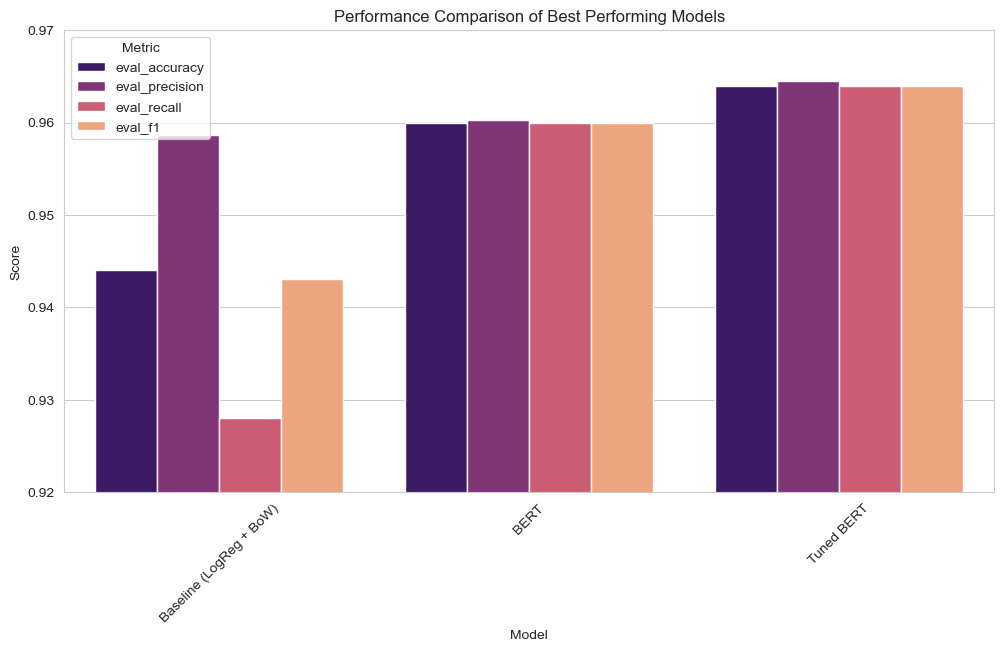

In [184]:
# Performance comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=final_results_df.melt(id_vars=["Model"],
    var_name="Metric",
    value_name="Score",
    value_vars=["eval_accuracy", "eval_precision", "eval_recall", "eval_f1"]),
    x="Model",
    y="Score",
    hue="Metric",
    palette="magma")

plt.title("Performance Comparison of Best Performing Models")
plt.xlabel("Model")
plt.ylabel("Score")
plt.ylim(0.92, 0.97)
plt.legend(title="Metric")
plt.xticks(rotation=45)
plt.show()

## Tuned BERT Model

In [194]:
# Evaluate predictions
tuned_bert_output = final_trainer.predict(test_dataset)
tuned_bert_y_true = tuned_bert_output.label_ids
tuned_bert_y_pred = tuned_bert_output.predictions.argmax(axis=-1)

# Get probabilities
tuned_bert_probs = softmax(tuned_bert_output.predictions, axis=1)

# Use probability for mlm
tuned_bert_pos_probs = tuned_bert_probs[:, 1]

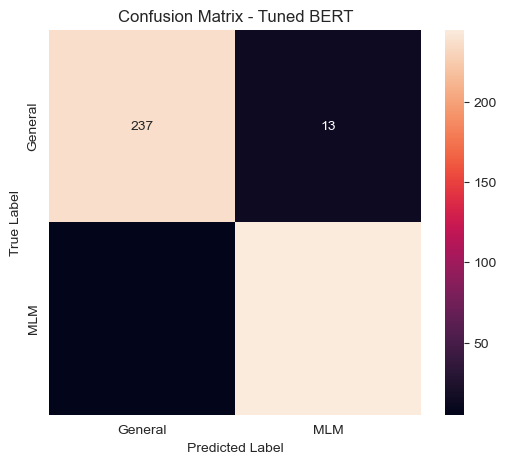

In [195]:
# Confusion Matrix
tuned_bert_conf_matrix = confusion_matrix(tuned_bert_y_true, tuned_bert_y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=["General", "MLM"], yticklabels=["General", "MLM"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Tuned BERT")
plt.show()

While tuned BERT model misclassified a few more “General” posts than the BoW model did (237 vs. 240 correct) the confusion matrix alone doesn’t tell the whole story. BERT still performs better overall because its precision/recall balance is stronger as shown in the precision-recall curve below.

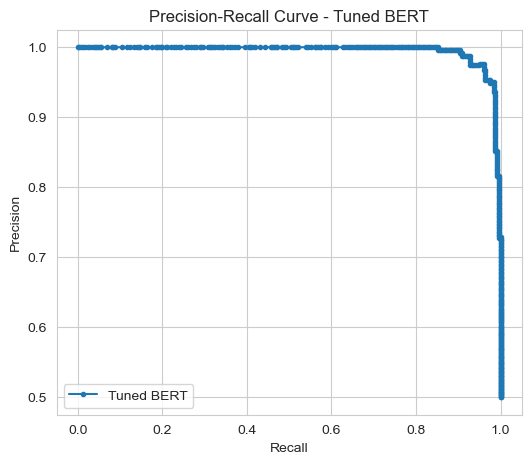

In [197]:
# Precision-Recall Curve
tuned_bert_precision, tuned_bert_recall, _ = precision_recall_curve(tuned_bert_y_true, tuned_bert_pos_probs)
plt.figure(figsize=(6, 5))
plt.plot(tuned_bert_recall, tuned_bert_precision, marker=".", label="Tuned BERT")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Tuned BERT")
plt.legend()
plt.show()

The tuned BERT curve is flatter and maintains higher precision at higher recall than the baseline BoW model, indicating that it balances precision and recall  better than the logistic regression baseline.

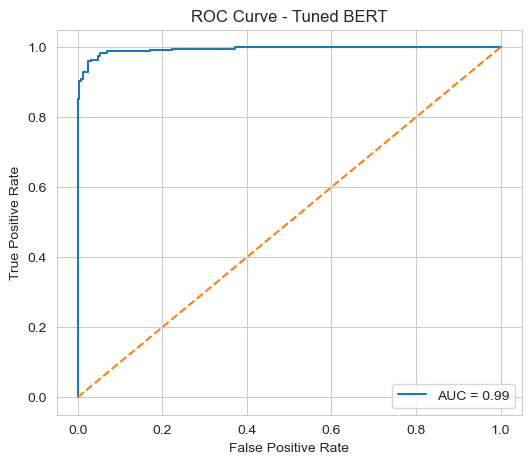

In [201]:
# ROC Curve
tuned_bert_fpr, tuned_bert_tpr, _ = roc_curve(tuned_bert_y_true, tuned_bert_pos_probs)

tuned_bert_roc_auc = auc(tuned_bert_fpr, tuned_bert_tpr)
plt.figure(figsize=(6, 5))
plt.plot(tuned_bert_fpr, tuned_bert_tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Tuned BERT")
plt.legend()
plt.show()

Both the tuned BERT and baseline BoW model have near-perfect classification performance with AUC values near 0.99. But the tuned BERT model shows a sharper rise toward the top-left corner which indicates stronger discrimination.

# Explainability with SHAP
SHAP (SHapley Additive exPlanations) is a game theory-based method that assigns each feature a contribution value, revealing how each word influences the model's prediction. We will use SHAP to break down BERT’s output into word-level contributions so that users can see exactly which words drove the decision.

In [383]:
import shap

# Load the tuned bert model and tokeniser
model = AutoModelForSequenceClassification.from_pretrained("./results/best_bert_model", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("./results/best_bert_tokenizer")

In [396]:
def predict_probabilities(texts):
    # Ensure the input is a list of strings
    texts = list(texts)
    
    # Tokenise batch of texts to tensors
    encodings = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    
    # Run model
    with torch.no_grad():
        outputs = model(**encodings)
        
    logits = outputs.logits  # shape: [batch_size, num_classes]
    
    # Convert to probabilities
    probs = torch.nn.functional.softmax(logits, dim=1).numpy()
    
    return probs[:, 1]

In [397]:
# Create the SHAP explainer
explainer = shap.Explainer(predict_probabilities, tokenizer)

## Testing

In [398]:
# Samples
sample_posts = vector_df['cleaned_for_sentiment'].sample(10, random_state=42)
print(sample_posts)

# Make list
sample_post_list = sample_posts.tolist()

1501    Working on my fitness ! ! ! Thank you Plexus f...
2586    Trying out bunch of new makeup products , read...
2653    What I eat in a day in Bali ! Meal 1 overnight...
1055    Vulnerable share ... A few weeks ago I was at ...
705     I don't mean to brag , but I do Arbonne is the...
106     What does time financial freedom mean for you ...
589     📍 Have you been praying for a job or opportuni...
2468    Invest in yourself , you're worth it 👌🏻 ✨ #inv...
2413    LONGRICH SUPERBKLEAN PANTY LINER Why you need ...
1600    ☀️ 🇺🇸 🎉 Happy Memorial Day ! 🎉 🇺🇸 ☀️ ☀️ What w...
Name: cleaned_for_sentiment, dtype: object


**Example 1**

In [399]:
sample_text_1 = str(sample_post_list[0])
print("Sample text:", sample_text_1)

Sample text: Working on my fitness ! ! ! Thank you Plexus for allowing me the opportunity to get to this point ! #poweredbyplexus #fitness #womenwholift 💪🏽 💕 ☀️ 😜 🦄


In [400]:
# Compute SHAP values
shap_values_1 = explainer([sample_text_1])

shap.plots.text(shap_values_1)

  0%|          | 0/498 [00:00<?, ?it/s]

**Example 2**

In [401]:
sample_text_2 = str(sample_post_list[5])
print("Sample text:", sample_text_2)

Sample text: What does time financial freedom mean for you ? What would you do differently if you didn't have to stress about finances or long hours at work ? What if I told you there was another way ? What if I told you you could make 10k - 20k a month from your phone ? Would you listen ? DM me to talk 🫶🏼 #highticketsales #highticketsalescoach #mentor #20kblueprint #changeyourlife


In [402]:
shap_values_2 = explainer([sample_text_2])

shap.plots.text(shap_values_2)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:11, 11.61s/it]               


**Example 3**

In [403]:
sample_text_3 = str(sample_post_list[2])
print("Sample text:", sample_text_3)

Sample text: What I eat in a day in Bali ! Meal 1 overnight oats ad Snack dark chocolate Meal 3 nasi gorang Snack corn Meal 4 pasta salad #healthy #healthyfood #healthylifestyle #bali #baliindonesia


In [404]:
shap_values_3 = explainer([sample_text_3])

shap.plots.text(shap_values_3)

  0%|          | 0/498 [00:00<?, ?it/s]

## Confidence score
We are able to calculate a confidence score by summing all the SHAP values and adding the base value (this sum corresponds to the model's predicted probability for the "mlm" class). If that probability (f_score) is at least 0.5 then the post is labelled "mlm" and we use f_score as the confidence percentage. If less than 0.5 we label it "general" and use (1 - f_score) as the confidence. This way, the returned confidence always reflects how certain the model is in its chosen classification.

In [405]:
def get_confidence_score(shap_values, threshold=0.5):
    f_score = float(shap_values[0].values.sum() + shap_values[0].base_values)

    if f_score >= threshold:
        label = "mlm"
        confidence = round(f_score * 100, 2)
    else:
        label = "general"
        confidence = round((1 - f_score) * 100, 2) # Flip for non-predicted class

    return {
        "label": label,
        "confidence": confidence
    }

**Example 1**

In [406]:
get_confidence_score(shap_values_1)

{'label': 'mlm', 'confidence': 99.99}

**Example 2**

In [407]:
get_confidence_score(shap_values_2)

{'label': 'mlm', 'confidence': 99.99}

**Example 3**

In [408]:
get_confidence_score(shap_values_3)

{'label': 'general', 'confidence': 99.97}

## Word level aggregation

The SHAP plots can be difficult to interpret because BERT’s WordPiece tokeniser sometimes breaks words (like tokenising "plexus" into "Pl," "ex," and "us") when the full word isn't in its vocabulary. As a result, SHAP scores can appear at the subword level, which makes it hard to see how entire words influence the classification. To create more web-friendly explanations, we'll aggregate subword scores back to the full word, so each word has a single combined SHAP value. Although this shifts the granularity away from subwords, it makes the results much clearer for users.

In [409]:
def get_word_level_shap(sample_text, shap_values, tokenizer):
    # Tokenise with offsets to map back to original words
    enc = tokenizer(sample_text, return_offsets_mapping=True, return_tensors="pt", truncation=True)
    tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"][0])
    word_ids = enc.word_ids()
    offsets = enc["offset_mapping"][0].tolist()
    token_shap_values = shap_values.values[0]

    word_offsets = {}
    word_shap = {}

    # Group token-level SHAP and offsets by word_id
    for id, word_id in enumerate(word_ids):
        if word_id is None:
            continue
        start, end = offsets[id]
        if start == end:
            continue

        if word_id in word_offsets:
            word_offsets[word_id] [1] = end
        else:
            word_offsets[word_id]  = [start, end]

        word_shap[word_id]  = word_shap.get(word_id,  0.0) + token_shap_values[id]

    word_level_scores = []
    skip_next_word = set()

    for i in sorted(word_offsets.keys()):
        if i in skip_next_word:
            continue

        start, end = word_offsets[i]
        word = sample_text[start:end]

        # Merge hashtags (if '#' and next word exists)
        if word == "#" and (i + 1) in word_offsets:
            next_start, next_end = word_offsets[i + 1]
            full_hashtag = sample_text[start:next_end]
            combined_shap = word_shap[i] + word_shap[i + 1]

            word_level_scores.append({
                "word": full_hashtag,
                "shap_value": round(combined_shap, 2)
            })

            skip_next_word.add(i + 1)  # Skip the next token (already merged in hashtag)
        elif word.strip():  # Add normal word if not empty
            word_level_scores.append({
                "word": word,
                "shap_value": round(word_shap[i], 2)
            })

    return word_level_scores

**Example 1**

In [410]:
get_word_level_shap(sample_text_1, shap_values_1, tokenizer)

[{'word': 'Working', 'shap_value': 0.0},
 {'word': 'on', 'shap_value': 0.0},
 {'word': 'my', 'shap_value': 0.0},
 {'word': 'fitness', 'shap_value': 0.0},
 {'word': '!', 'shap_value': -0.0},
 {'word': '!', 'shap_value': 0.0},
 {'word': '!', 'shap_value': 0.0},
 {'word': 'Thank', 'shap_value': -0.01},
 {'word': 'you', 'shap_value': 0.01},
 {'word': 'Plexus', 'shap_value': 0.43},
 {'word': 'for', 'shap_value': 0.0},
 {'word': 'allowing', 'shap_value': 0.02},
 {'word': 'me', 'shap_value': 0.01},
 {'word': 'the', 'shap_value': 0.01},
 {'word': 'opportunity', 'shap_value': 0.0},
 {'word': 'to', 'shap_value': -0.01},
 {'word': 'get', 'shap_value': 0.01},
 {'word': 'to', 'shap_value': -0.0},
 {'word': 'this', 'shap_value': 0.0},
 {'word': 'point', 'shap_value': 0.0},
 {'word': '!', 'shap_value': 0.02},
 {'word': '#poweredbyplexus', 'shap_value': 0.16},
 {'word': '#fitness', 'shap_value': 0.05},
 {'word': '#womenwholift', 'shap_value': 0.14},
 {'word': '💪🏽', 'shap_value': 0.02},
 {'word': '💕', 

**Example 2**

In [411]:
get_word_level_shap(sample_text_2, shap_values_2, tokenizer)

[{'word': 'What', 'shap_value': 0.0},
 {'word': 'does', 'shap_value': -0.0},
 {'word': 'time', 'shap_value': -0.0},
 {'word': 'financial', 'shap_value': 0.07},
 {'word': 'freedom', 'shap_value': 0.05},
 {'word': 'mean', 'shap_value': 0.0},
 {'word': 'for', 'shap_value': 0.0},
 {'word': 'you', 'shap_value': 0.0},
 {'word': '?', 'shap_value': -0.0},
 {'word': 'What', 'shap_value': 0.0},
 {'word': 'would', 'shap_value': 0.0},
 {'word': 'you', 'shap_value': 0.01},
 {'word': 'do', 'shap_value': 0.01},
 {'word': 'differently', 'shap_value': 0.01},
 {'word': 'if', 'shap_value': 0.01},
 {'word': 'you', 'shap_value': 0.01},
 {'word': 'didn', 'shap_value': 0.0},
 {'word': "'", 'shap_value': 0.0},
 {'word': 't', 'shap_value': 0.0},
 {'word': 'have', 'shap_value': 0.0},
 {'word': 'to', 'shap_value': 0.0},
 {'word': 'stress', 'shap_value': 0.01},
 {'word': 'about', 'shap_value': 0.01},
 {'word': 'finances', 'shap_value': 0.05},
 {'word': 'or', 'shap_value': 0.0},
 {'word': 'long', 'shap_value': -0.

**Example 3**

In [412]:
get_word_level_shap(sample_text_3, shap_values_3, tokenizer)

[{'word': 'What', 'shap_value': -0.0},
 {'word': 'I', 'shap_value': -0.0},
 {'word': 'eat', 'shap_value': -0.0},
 {'word': 'in', 'shap_value': -0.0},
 {'word': 'a', 'shap_value': 0.0},
 {'word': 'day', 'shap_value': 0.0},
 {'word': 'in', 'shap_value': 0.0},
 {'word': 'Bali', 'shap_value': 0.0},
 {'word': '!', 'shap_value': -0.0},
 {'word': 'Meal', 'shap_value': -0.0},
 {'word': '1', 'shap_value': 0.0},
 {'word': 'overnight', 'shap_value': 0.0},
 {'word': 'oats', 'shap_value': -0.0},
 {'word': 'ad', 'shap_value': -0.0},
 {'word': 'Snack', 'shap_value': -0.0},
 {'word': 'dark', 'shap_value': -0.0},
 {'word': 'chocolate', 'shap_value': -0.0},
 {'word': 'Meal', 'shap_value': -0.0},
 {'word': '3', 'shap_value': -0.0},
 {'word': 'nasi', 'shap_value': -0.0},
 {'word': 'gorang', 'shap_value': -0.0},
 {'word': 'Snack', 'shap_value': -0.0},
 {'word': 'corn', 'shap_value': -0.0},
 {'word': 'Meal', 'shap_value': 0.0},
 {'word': '4', 'shap_value': -0.0},
 {'word': 'pasta', 'shap_value': -0.0},
 {'w

# Conclusion

While the baseline BoW model achieved solid results, our tuned BERT model consistently outperformed it in terms of accuracy, precision, recall, and F1. BERT’s ability to capture contextual nuances gave it an edge in identifying MLM posts and by integrating SHAP for word-level explainability, we ensure users can see exactly why a post was labelled as being MLM related. 

With the model and SHAP explanations packaged into our extension, users will be able to view a heatmap of influential words directly in their browser, promoting transparency and deeper critical engagement with exploitative MLM content.